# **Part Processing Classification**

***
**Name: Tim Fuger**

**Date: 5/19/23**
***

# Business Understanding

## Background

Manufacturing as a whole has the second largest potential for automation in the industry. This is according to Mckinsey from an article in 2017 titles "Human + machine" which outlined an analysis on the industry (see the chart below which measured the manufacturing work in 46 different countries covering about 80 percent of the global workforce):

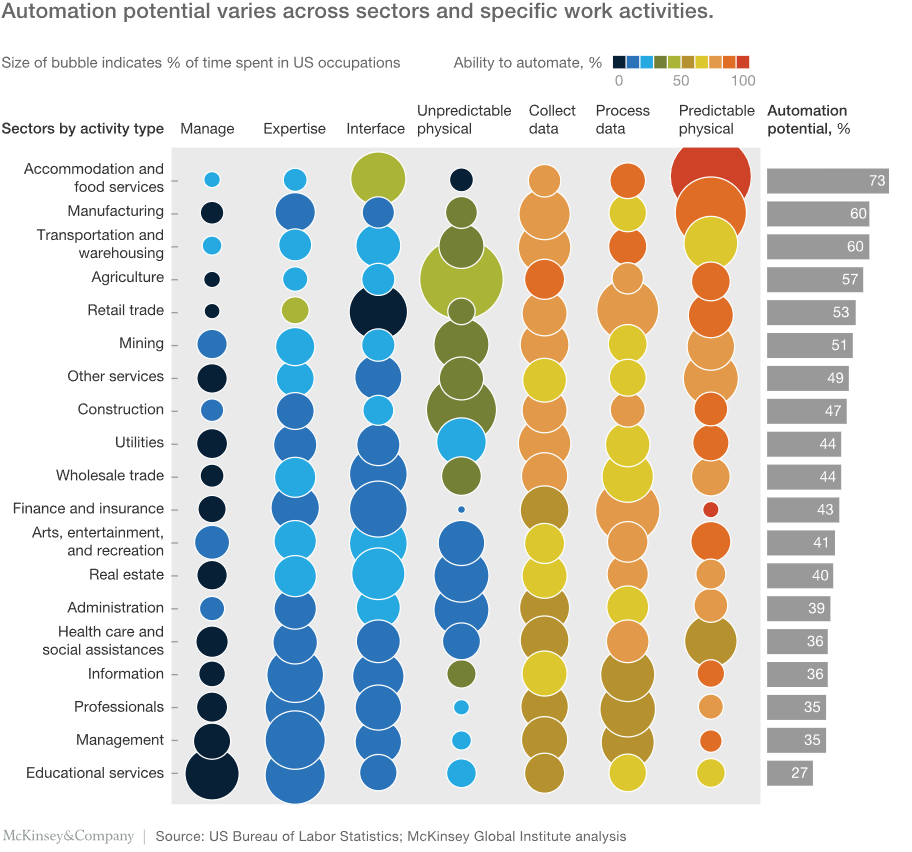

https://www.mckinsey.com/capabilities/operations/our-insights/human-plus-machine-a-new-era-of-automation-in-manufacturing#/

According to ther article, in manufacturing "87 percent of hours are spent on activities performed by workers in production occupations [which] are automatable." Since then manufacturing has begun to automate these production occupation hours, but what has changed since then is the rapid development of AI technologies. These developments could help not only the production departments buyt other departments as well. In engineering pecifically, Mckinsey estimates that 45 percent of working hours are automatable. Cutting down on any of this time would boost effiencies in any company exponentially.

## Business Problem

> Our stakeholder is looking to **reduce engineering time and error** to **assign the manufacturing process** for a custom fabricated **part**.

Our client Fab Inc. is a custom architecture millwork and metalwork manufacturer. They have already worked to automate large portions of the shop/production floor by having robots and more sophisticated machinery and software work in tandem with shop employees. Since upgrading production equipment and processes, they have seen the bottleneck in their facility start to shift from the production departments to their engineering and design departments. With the increased efficiency in production, the shop floor is always ahead of engineering and design, which means that the shop is consistently waiting on digital files and shop documentation in order to continue working on projects. They would like to boost the automation in the engineering and design departments.

Our client's long term goal is to create a system which can automatically identify and program parts for various assemblies. This in turn will reduce the amount of engineering time required for each project, and will free the team up to focus on other responsibilities. For this project is the catalyst of this long term goal. It will start by classifying the first step in the manufacturing process for each of the parts.

## Objective

> To develop a **convolutional nueral network** that can properly **identify** the **required processes** for each **3D modeled part**.

## Defining Metrics

The metric that is most important in our analysis is precision. We need to be really precise in our predictions, as an imprecise prediction means a material gets sent to the wrong workcell. This, at the least, means lost time for sending the material back to the previous station, but, at the worst, it could mean lost time and lost material if someone cuts stock they should not be cutting. And for the most expensive process, we will want to have that process be as precise. That process will incur the highest time and material cost so we do not want anything being sent to that process that isnt the correct material or part, as it would cost the highest in lost time and material.

Our second metric to use (should there be only slight precision differences between models) will be F1-score. This will help us to balance precision against recall as we analyze the models.

## The Dataset

The dataset contains around 1000 models which are all parametric variations on 10 different types of fixtures. These models were collected over the course of a month as they passed from the engineering department to the production department. Each fixture is made up of a variety of parts, with each part having a different shape and a different material assigned. The parts make up assemblies which are identified and shown in the table below.

| Assembly  | Type  |
|---|---|
| Cab1  | Base Cabinet  |
| Cab2  | Wall Cabinet  |
| Cab3  | Pantry Cabinet  |
| Shelf1  | Removable Shelf  |
| Shelf2  | Floating Shelf  |
| Counter1  | Order Counter  |
| Station1  | Utensil Station  |
| Bench1  | Bench with back  |
| Bench2  | Bench with no back  |
| Table1  | Table  |

All of the original solidworks models of these assemblies are located in the SW_Models folder. Each of these solidworks models have a design table which has multiple configurations of each assembly. For example, Station2 has 21 configurations of its model (not including the default configuration which was not used in this project). Each of these configurations have a different length, and width so as to create varied parts for the models to process. All of the different variations and the attributes of each are detailed in the file "Part_classification-Variations.csv" file.

After all of the models and configurations were setup, each of the solidworks models were converted to meshes by using a well built script by SigmaRelief off of github, which you can find at the link below:

https://github.com/SigmaRelief/SOLIDWORKS-Export-to-Mesh

All of these converted meshes were stored in the Meshes folder of this repo. The naming convention of the meshes used the following default naming strategy:

*Assembly-Configuration - PartName*

Example:
The first part of the first configuration of Bench1 is:

Bench1-01 - Bench1-01-1


## Modeling

The modeling uses the PointNet architecture in order to process the mesh files. This approach utilizes a nueral network through pytorch, where all of the data being fed into the model is resampled to have the same size.

Our models include one base model, an augmented data model, and a fine tuned model. All of the models have a Logsoftmax function in order to generate probabilities for each of the classes of the multiclass classification problem. We will show that the fine tuned model seems to give us the best results due to the additional convolutional layers, dropout layers, and specialized AdamW optimizer. 

# Data Understanding

## Loading Packages

We will start by importing the libraries required for the notebook and pulling in the data:

In [133]:
#import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
sns.set(rc={'savefig.dpi':300, 'figure.figsize':(12,8)})
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import trimesh
import numpy as np
from numpy.random import default_rng
import math
import random
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from torch.nn.functional import normalize
from pytorch3d.io import load_obj
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.structures import Meshes
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
import sys
import tkinter.filedialog as tkfd
import time

# suppress material file warning from pytorch3d
import warnings
warnings.filterwarnings("ignore", message="No mtl file provided")
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# define function to set random seeds for python random, numpy and pytorch
def set_seed(seed: int = 42) -> None:
    # np.random.seed(seed)
    random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    # os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [3]:
# Run set_seed function
set_seed()

Random seed set as 42


## Plotting Sample Meshes

Lets take a look at some of the mesh files to get a better idea of the data we are working with.

In [4]:
# Set the base directory for where the original files are located
base_dir = 'Meshes/0_FabInc_NoClass'
files_dir = []
files_dir = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if os.path.isfile(os.path.join(base_dir, f))]
base_meshes = []

# Start a random generator and randomly load meshes from the directory
rng = default_rng(seed=49)
rand_nums = rng.choice(len(files_dir), size=9, replace=False)
for i in rand_nums:
    base_meshes.append((trimesh.load_mesh(files_dir[i]), str(files_dir[i])))

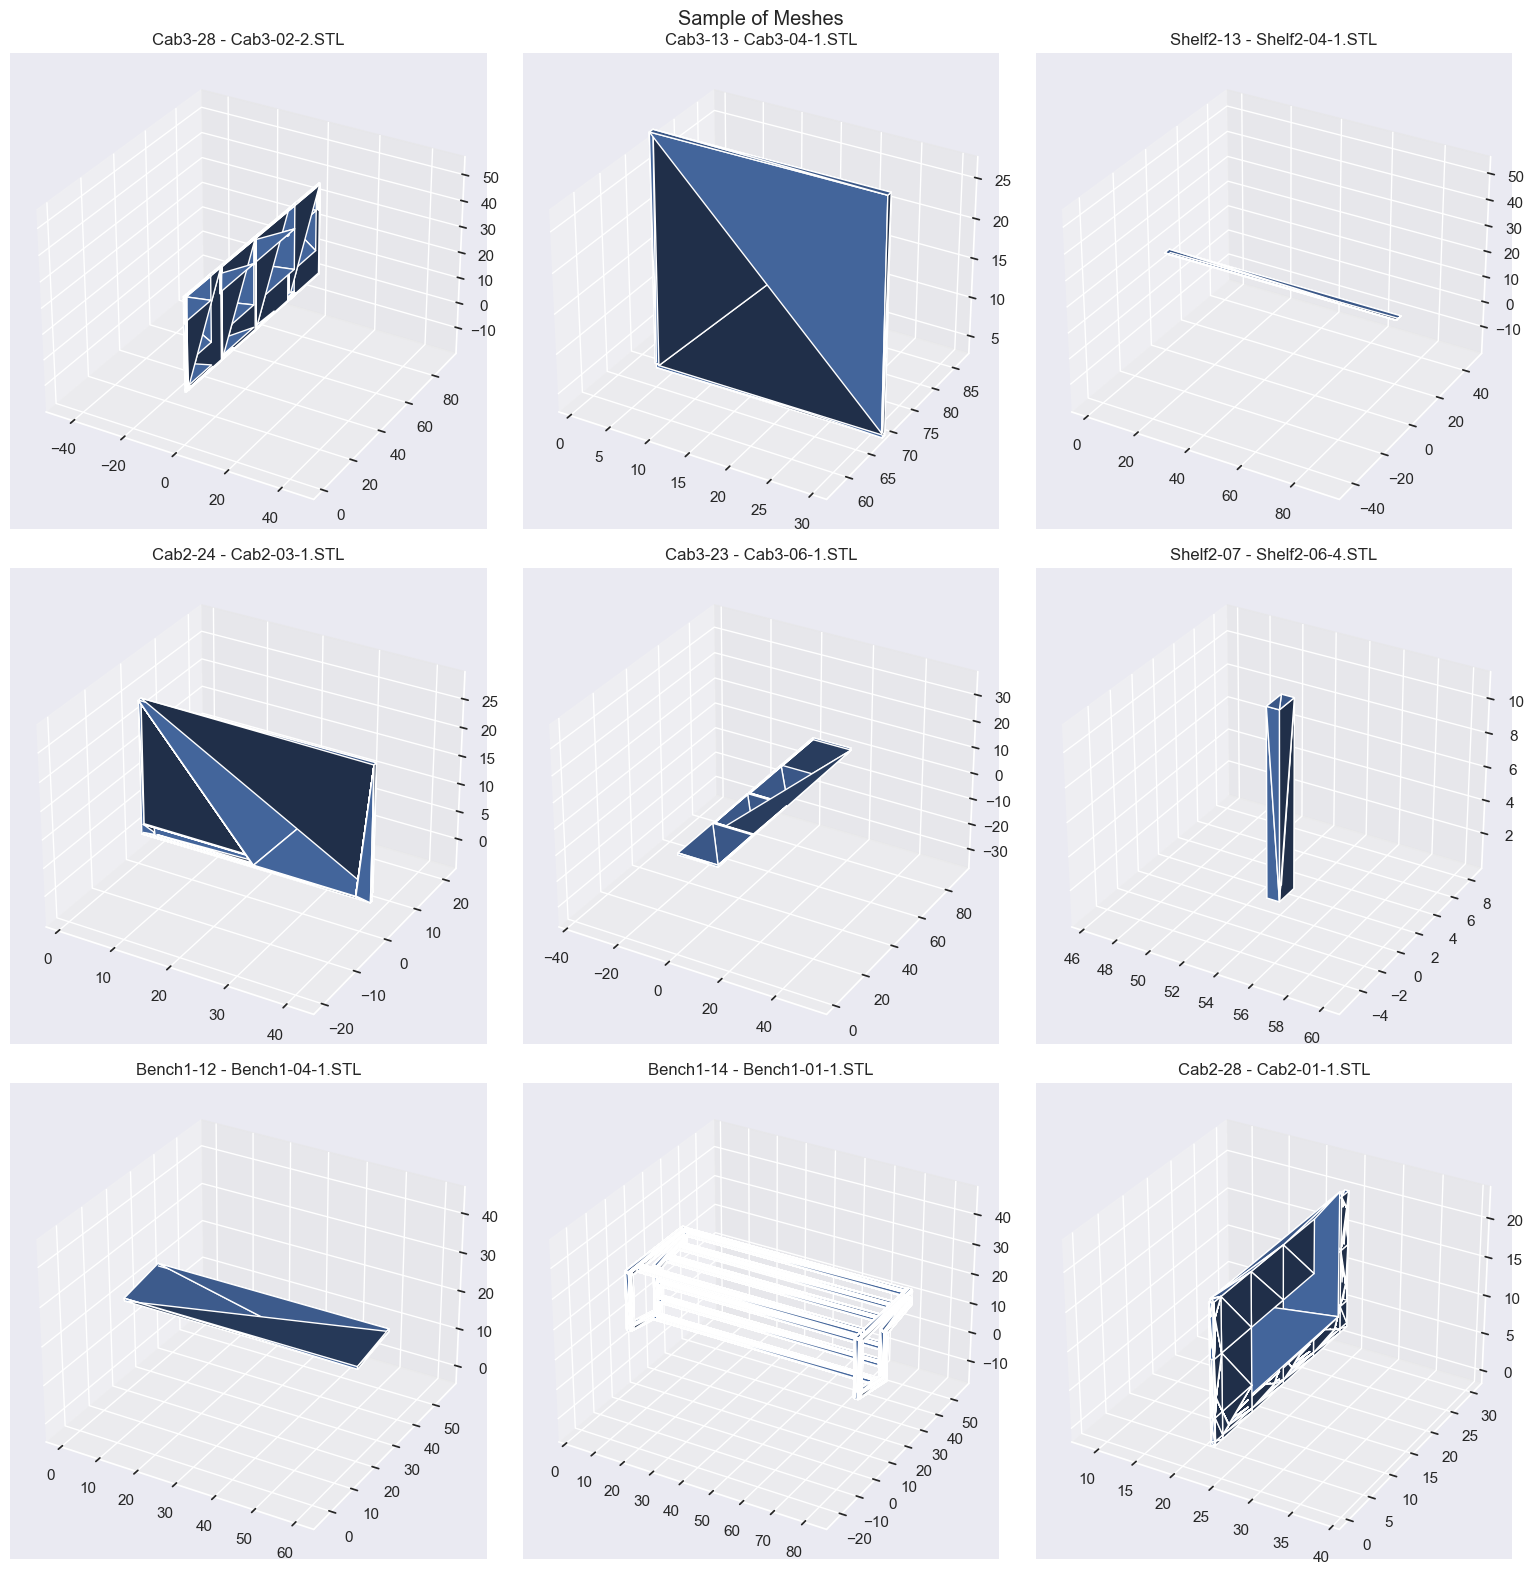

In [5]:
# Plot multiple plots from sample of meshes

i = 0
fig = plt.figure(figsize=(16,16))
fig.suptitle('Sample of Meshes')

for mesh, file_name in base_meshes:
    ax = plt.subplot(3,3,i+1, projection='3d')
    ax.plot_trisurf(mesh.vertices[:,0], mesh.vertices[:,1], triangles=mesh.faces, Z=mesh.vertices[:,2])
    # ax.set_xlim3d(0, 60)
    # ax.set_ylim3d(0, 60)
    # ax.set_zlim3d(0, 60)
    plt.axis('equal')
    plt.title(file_name.split('\\',1)[1])
    plt.tight_layout()
    i += 1

plt.savefig('Visualizations/Sample-of-Meshes.png', bbox_inches='tight');

Looks like we have a variety of different shapes, and vertices. Most likely all of these parts also vary in material as well.

## Plot Target classes

Lets create a target dataframe, get the values of the target classes in the dataframe and plot the class values.

In [6]:
# load target csv file into pandas dataframe
df_target = pd.read_csv('Part_Classification.csv')
df_target

Iteration  Part Name          Material Manufacturing Process
0          1.0  Bench1-01  Hot Rolled Steel        Metal Band Saw
1          1.0  Bench1-02         White Oak             Panel Saw
2          1.0  Bench1-03         White Oak             Panel Saw
3          1.0  Bench1-04         White Oak             Panel Saw
4          2.0  Bench1-01  Hot Rolled Steel        Metal Band Saw
..         ...        ...               ...                   ...
990       24.0  Table1-02  Hot Rolled Steel        Metal Band Saw
991       25.0  Table1-02  Hot Rolled Steel        Metal Band Saw
992       26.0  Table1-02  Hot Rolled Steel        Metal Band Saw
993       27.0  Table1-02  Hot Rolled Steel        Metal Band Saw
994       28.0  Table1-02  Hot Rolled Steel        Metal Band Saw

[995 rows x 4 columns]

Lets take a look at the material types that we have and the manufacturing processes we have.

In [7]:
# Show number of data points of each class
print(df_target['Material'].value_counts())
print(df_target['Manufacturing Process'].value_counts())

TFL                 500
White Oak           235
MDF                  84
Hot Rolled Steel     83
Stainless Steel      75
Caesarstone          18
Name: Material, dtype: int64
CNC               494
Panel Saw         325
Metal Band Saw     80
Metal Laser        78
Waterjet           18
Name: Manufacturing Process, dtype: int64


In [8]:
# Calculate percentages for each class
Value_counts = df_target['Manufacturing Process'].value_counts(normalize=True)*100
Vcts = [round(item, 2) for item in list(Value_counts.to_dict().values())]
Vcts

[49.65, 32.66, 8.04, 7.84, 1.81]

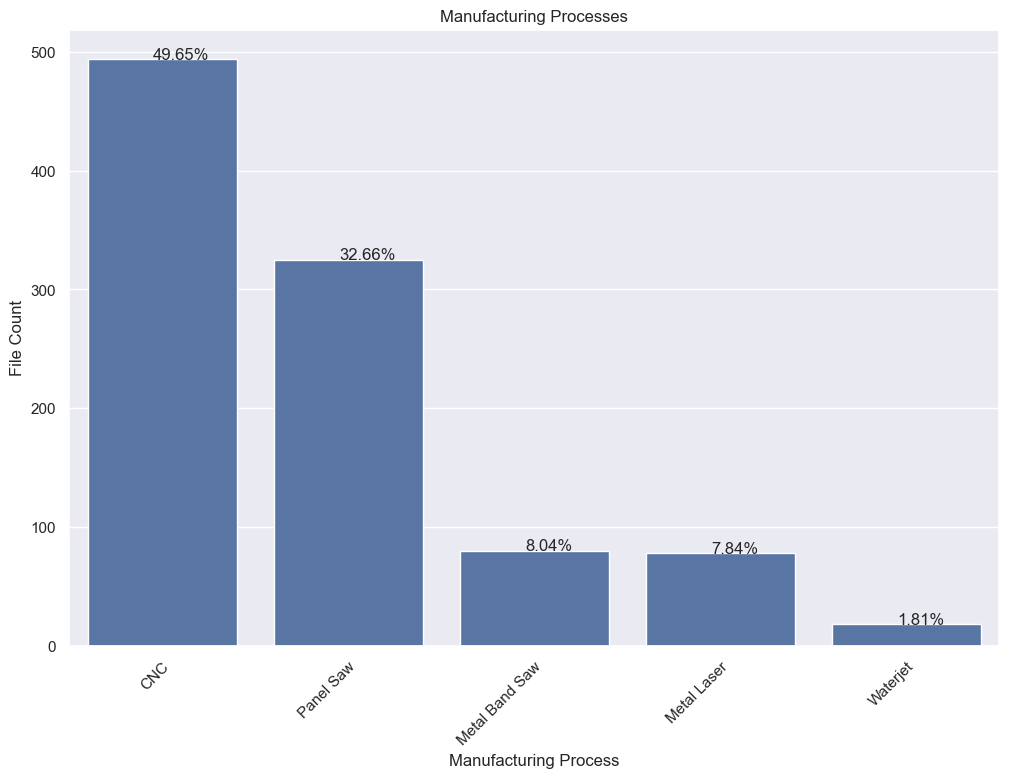

In [9]:
# Plot class types and class percentages in barplot

Manu_type = df_target['Manufacturing Process'].value_counts(sort=True)
Value_counts = df_target['Manufacturing Process'].value_counts(normalize=True)*100
vctsdict = Value_counts.to_numpy()

ax = sns.barplot(x=Manu_type.index, y=Manu_type.values, color='b')
ax.set(xlabel='Manufacturing Process', ylabel='File Count', title='Manufacturing Processes')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

for val, p in enumerate(ax.patches):
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate((str(Vcts[val]) + '%'), (x, y), size = 12)

plt.savefig('Visualizations/Manufacturing-Processes-Bar-Chart.png', bbox_inches='tight')        
plt.show();

Looks like we have a severe class imbalance. So we will need to do accomodate for this in our data preparation to adjust for this imbalance.

## Engineering Time and Error

The copmpany has let us know that each engineer spends an average of 10 seconds assigning a part to a manufacturing process. Out of the supposed 995 parts we have, that would mean that to assign all of those parts would cost the department 166 minutes per month. Not a large amount of time on its own, but due to the constant shifting capacity in the plant, parts typically have to reassigned to different machines. This reassigning not only incurs three times as much time, it also results in a 7% error for assigning parts.

This would mean that it costs the department 498 minutes in engineering time per month and a 7% error for any assigning that happens. We would need to figure out what this 7% error would turn out to be.

## Time and Material Cost Analysis

In order to get a better idea of the cost of error from a misprediction, we will calculate the cost of time and material as they relate to the target classes (manufacturing processes). Lets start first with calculating time required.

Each of these machining processes take a certain amount of time in order to setup the machine and cut the material. We do not have definitive statistics that detail the average amount of time for each process, but we do have estimates from the company for the estimated cut time per item (in minutes) and the machining cost per hour. We will use these estimates to formulate a total cost of machining time per month.

In [10]:
# Create a dictionary from data acquired from FabInc
Cost_Time = {'Manufacturing Process': ['CNC', 'Metal Band Saw', 'Metal Laser', 'Panel Saw', 'Waterjet'], 
    'Estimated Cut Time per Item (minutes)': [30, 30, 25, 15, 60],
    'Machining Cost per Hour ($)': [150, 90, 250, 110, 175]}

# Create pandas dataframe of information
Cost_Time_df = pd.DataFrame(Cost_Time).set_index('Manufacturing Process')

# Create additional columns to calculate "time cost per month"
Cost_Time_df['Estimated Cut Time per Item (hours)'] = Cost_Time_df['Estimated Cut Time per Item (minutes)']/60
Cost_Time_df['Average Machine Time Cost per item ($)'] = Cost_Time_df['Estimated Cut Time per Item (hours)'] * Cost_Time_df['Machining Cost per Hour ($)']
Cost_Time_df['Total Items'] = Manu_type
Cost_Time_df['Time Cost per month ($)'] = Cost_Time_df['Total Items'] * Cost_Time_df['Average Machine Time Cost per item ($)']
Cost_Time_df

Estimated Cut Time per Item (minutes)  \
Manufacturing Process                                          
CNC                                                       30   
Metal Band Saw                                            30   
Metal Laser                                               25   
Panel Saw                                                 15   
Waterjet                                                  60   

                       Machining Cost per Hour ($)  \
Manufacturing Process                                
CNC                                            150   
Metal Band Saw                                  90   
Metal Laser                                    250   
Panel Saw                                      110   
Waterjet                                       175   

                       Estimated Cut Time per Item (hours)  \
Manufacturing Process                                        
CNC                                               0.500000   
Metal Band Saw                                    0.500000   
Metal Laser                                       0.416667   
Panel Saw                                         0.250000   
Waterjet                                          1.000000   

                       Average Machine Time Cost per item ($)  Total Items  \
Manufacturing Process                                                        
CNC                                                 75.000000          494   
Metal Band Saw                                      45.000000           80   
Metal Laser                                        104.166667           78   
Panel Saw                                           27.500000          325   
Waterjet                                           175.000000           18   

                       Time Cost per month ($)  
Manufacturing Process                           
CNC                                    37050.0  
Metal Band Saw                          3600.0  
Metal Laser                             8125.0  
Panel Saw                               8937.5  
Waterjet                                3150.0

We will also want to take a look at the materials and their cost implications. 

For all of the materials, we can calculate the square footage price of each of the products, and then compare what a typical material cut mistake would cost. We can then correlate the materials to the manufacturing processes to see which one will be the most important in incurring cost due to error.

FabInc gave us initial cost per stock and average stock item yield per part to start with.

In [11]:
# Create a dictionary from data acquired from FabInc
Cost_Material = {'Material': ['Caesarstone', 'Hot Rolled Steel', 'MDF', 'Stainless Steel', 'TFL', 'White Oak'], 
     'Assumed Standard Size': ['305cm x 144cm x 2cm', '48" x 96" x 16 gauge', '49" x 97" x 3/4"', '48" x 96" x 16 gauge', '49" x 97" x 3/4"', '7" x 60" x 3/4"'],
    'Cost per stock item ($)': [1200, 420, 45, 670, 35, 10.90],
    'Stock item yield per part': [0.21, 0.13, 0.43, 0.18, 0.78, 3.24]}

# Create pandas dataframe of information
Cost_Material_df = pd.DataFrame(Cost_Material).set_index('Material')

# Create additional columns to calculate "Cost per item"
Cost_Material_df['Cost per item ($)'] = Cost_Material_df['Cost per stock item ($)']*Cost_Material_df['Stock item yield per part']
Cost_Material_df

Assumed Standard Size  Cost per stock item ($)  \
Material                                                          
Caesarstone        305cm x 144cm x 2cm                   1200.0   
Hot Rolled Steel  48" x 96" x 16 gauge                    420.0   
MDF                   49" x 97" x 3/4"                     45.0   
Stainless Steel   48" x 96" x 16 gauge                    670.0   
TFL                   49" x 97" x 3/4"                     35.0   
White Oak              7" x 60" x 3/4"                     10.9   

                  Stock item yield per part  Cost per item ($)  
Material                                                        
Caesarstone                            0.21            252.000  
Hot Rolled Steel                       0.13             54.600  
MDF                                    0.43             19.350  
Stainless Steel                        0.18            120.600  
TFL                                    0.78             27.300  
White Oak                              3.24             35.316

In [12]:
# Create a crosstab of material vs manufacturing process
crosstab = pd.crosstab(df_target['Manufacturing Process'], df_target['Material'], margins=True)
crosstab

Material               Caesarstone  Hot Rolled Steel  MDF  Stainless Steel  \
Manufacturing Process                                                        
CNC                              0                 0   70                0   
Metal Band Saw                   0                65    0               15   
Metal Laser                      0                18    0               60   
Panel Saw                        0                 0   14                0   
Waterjet                        18                 0    0                0   
All                             18                83   84               75   

Material               TFL  White Oak  All  
Manufacturing Process                       
CNC                    424          0  494  
Metal Band Saw           0          0   80  
Metal Laser              0          0   78  
Panel Saw               76        235  325  
Waterjet                 0          0   18  
All                    500        235  995

In [13]:
# Multiply crosstab by material cost per item
Cost_Material_Process = crosstab.multiply(Cost_Material_df['Cost per item ($)'].T, axis='columns')

# Sum all rows to recreate 'All' column
Cost_Material_Process['All'] = pd.DataFrame(Cost_Material_Process.sum(axis=1))

# Format 'All' column to be positioned at end of dataframe
temp_cols=Cost_Material_Process.columns.tolist()
new_cols=temp_cols[1:] + temp_cols[0:1]
Cost_Material_Process=Cost_Material_Process[new_cols]
Cost_Material_Process

Material               Caesarstone  Hot Rolled Steel     MDF  Stainless Steel  \
Manufacturing Process                                                           
CNC                            0.0               0.0  1354.5              0.0   
Metal Band Saw                 0.0            3549.0     0.0           1809.0   
Metal Laser                    0.0             982.8     0.0           7236.0   
Panel Saw                      0.0               0.0   270.9              0.0   
Waterjet                    4536.0               0.0     0.0              0.0   
All                         4536.0            4531.8  1625.4           9045.0   

Material                   TFL  White Oak       All  
Manufacturing Process                                
CNC                    11575.2       0.00  12929.70  
Metal Band Saw             0.0       0.00   5358.00  
Metal Laser                0.0       0.00   8218.80  
Panel Saw               2074.8    8299.26  10644.96  
Waterjet                   0.0       0.00   4536.00  
All                    13650.0    8299.26  41687.46

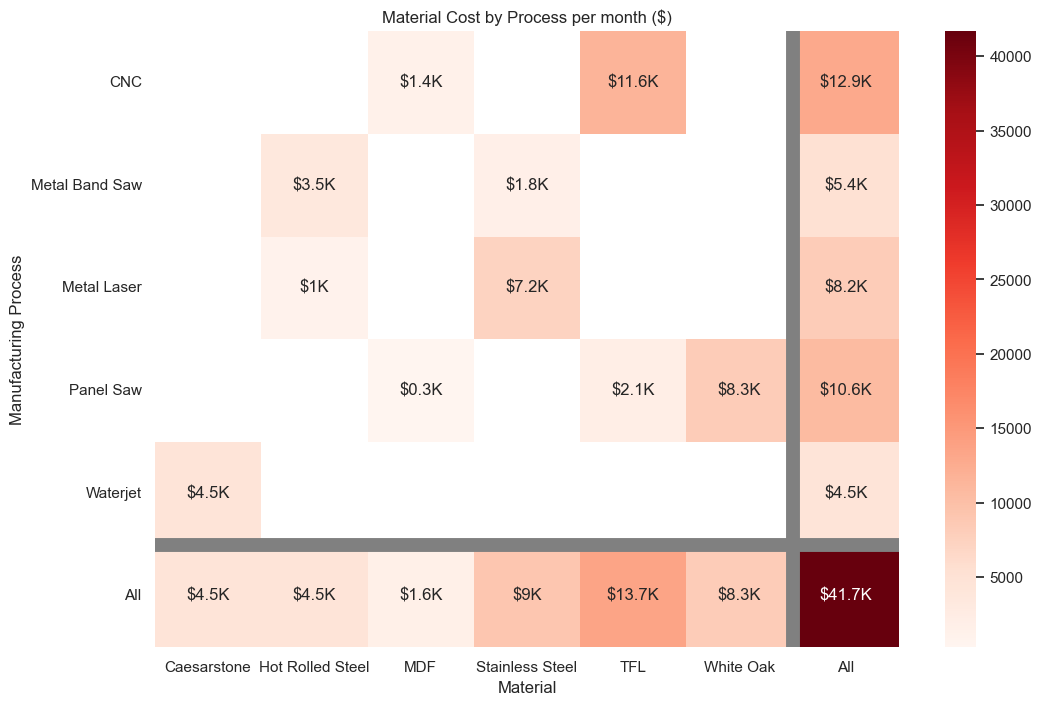

In [14]:
# Create heatmap of 'Material Cost per month'

df_cost_material_formatted = Cost_Material_Process.applymap(
    lambda val: f'${val / 1000:,.0f}K' if round(val / 100) % 10 == 0 else f'${val / 1000:,.1f}K')

ax = sns.heatmap(Cost_Material_Process,
           annot=df_cost_material_formatted,
           cmap='Reds',
           fmt='',
           mask=(Cost_Material_Process==0)
           )
ax.set_facecolor('white')
ax.axvline([6], *ax.get_ylim(), linewidth=10, color='gray')
ax.axhline([5], *ax.get_ylim(), linewidth=10, color='gray')
plt.yticks(rotation=0)
plt.title("Material Cost by Process per month ($)")
plt.savefig('Visualizations/Material-Cost.png', bbox_inches='tight');

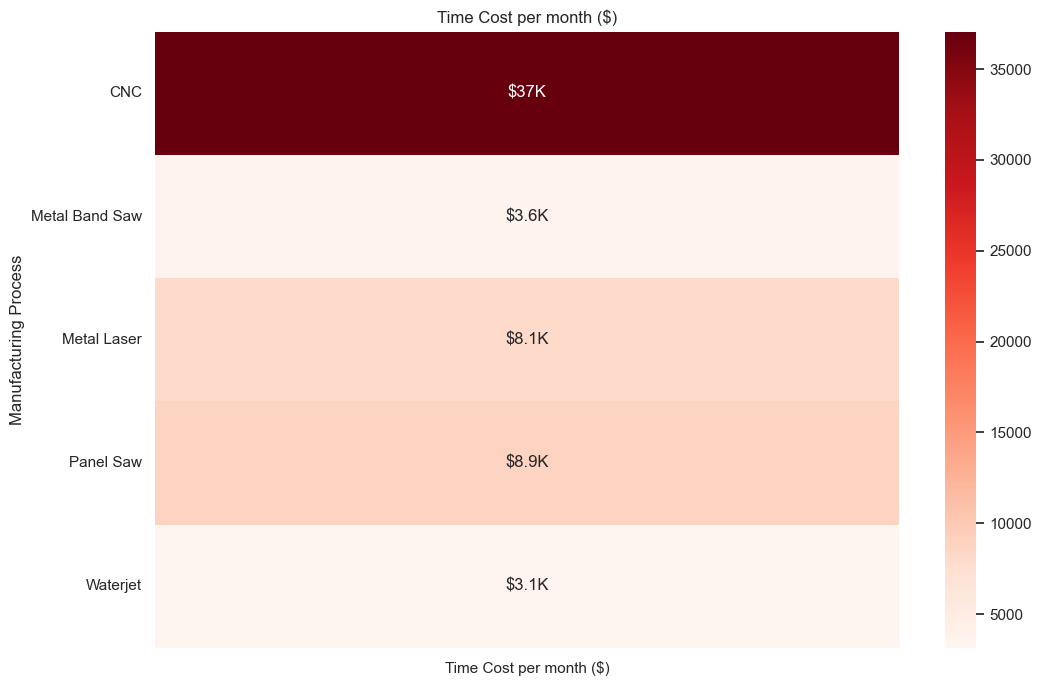

In [15]:
# Create heatmap of 'Time Cost per Month'

df_cost_time_formatted = Cost_Time_df['Time Cost per month ($)'].to_frame().applymap(
    lambda val: f'${val / 1000:,.0f}K' if round(val / 100) % 10 == 0 else f'${val / 1000:,.1f}K')
ax = sns.heatmap(Cost_Time_df['Time Cost per month ($)'].to_frame(),
           annot=df_cost_time_formatted,
           cmap='Reds',
           fmt=''
           )
plt.yticks(rotation=0)
plt.title("Time Cost per month ($)")
plt.savefig('Visualizations/Time-Cost.png', bbox_inches='tight');

In [16]:
# Create a totals dataframe, combining values from material and time costs
total_df = pd.DataFrame(data=[Cost_Time_df['Time Cost per month ($)'], Cost_Material_Process['All'].rename('Material Cost per month ($)')]).T
total_df['Total'] = total_df['Time Cost per month ($)'] + total_df['Material Cost per month ($)']
total_df.drop('All', axis=0, inplace=True)
total_df.loc['Total'] = total_df.sum(numeric_only=True)
total_df

Time Cost per month ($)  Material Cost per month ($)  \
Manufacturing Process                                                         
CNC                                    37050.0                     12929.70   
Metal Band Saw                          3600.0                      5358.00   
Metal Laser                             8125.0                      8218.80   
Panel Saw                               8937.5                     10644.96   
Waterjet                                3150.0                      4536.00   
Total                                  60862.5                     41687.46   

                           Total  
Manufacturing Process             
CNC                     49979.70  
Metal Band Saw           8958.00  
Metal Laser             16343.80  
Panel Saw               19582.46  
Waterjet                 7686.00  
Total                  102549.96

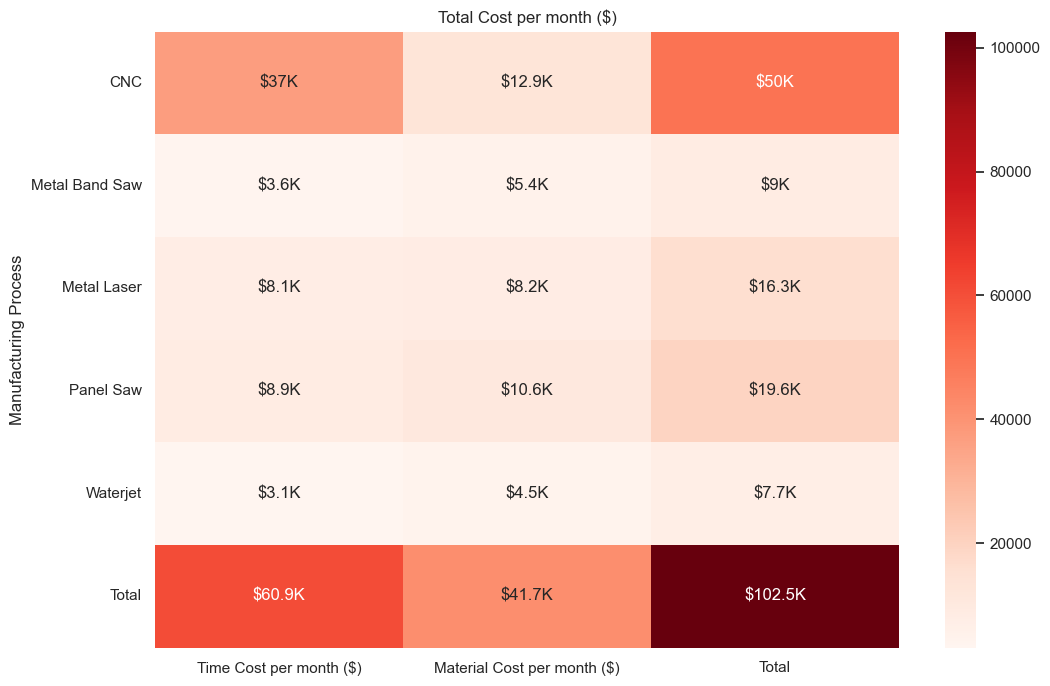

In [17]:
# Create heatmap of total_df
df_total_formatted = total_df.applymap(
    lambda val: f'${val / 1000:,.0f}K' if round(val / 100) % 10 == 0 else f'${val / 1000:,.1f}K')
ax = sns.heatmap(total_df,
           annot=df_total_formatted,
           cmap='Reds',
           fmt=''
           )
plt.yticks(rotation=0)
plt.title("Total Cost per month ($)")
plt.savefig('Visualizations/Time-Material-Cost.png', bbox_inches='tight');

Out of all of the classes, it looks like the CNC process by far has the largest total cost per month. This one class is more than four times larger than the next largest class (Panel Saw) and actually makes up 71% of the total cost of all the manufacturing processes. When we look at our metrics, we will want to optimize for CNC the most in order to reduce costs.

So just looking at the total cost, in the worst case scenario where parts are misassigned and they end up being cut (which is highly unlikely due to the materials only being able to cut certain materials) a 7% error rate would result in:

In [18]:
print('$', "{:,}".format(total_df.loc['Total','Total'] * 0.07))

$ 7,178.4972


This is a price that we need to work down, as it is definitely too high.

We should be able to use this data later on in the modeling to compare the precision of the model, and use it to calculate a total estimated error cost of the model that can be compared to the currenty cost of the engineering department.

## Explore Data Directory

We will want to load in the data showing what is actually in the file directory where all of our mesh files are located. These files may or may not match what we have been given in the target csv file.

https://towardsdatascience.com/how-to-create-a-list-of-files-folders-and-subfolders-and-then-export-as-excel-6ce9eaa3867a

In [19]:
# Create a function to generate a dataframe including information on files in a given directory

d_ext_desc = {'csv':'CSV file',
              'db':'Thumbnail',
              'doc':'Microsoft Word Document',
              'docx':'Microsoft Word Document',
              'GIF':'GIF Image file',
              'html':'HTML file',
              'ico':'Icon Image file',
              'jpg':'JPG Image file',
              'JPEG':'JPEG Image file',
              'json':'JSON file',
              'lnk':'Shortcut file',
              'msg':'Microsoft Outlook Message file',
              'pdf':'PDF file',
              'pkl':'Pickle (python) file',
              'png':'PNG Image file',
              'ppt':'Microsoft Powerpoint file',
              'pptx':'Microsoft Powerpoint file',
              'pst':'Microsoft Outlook Data file',
              'py':'Python file',
              'pyc':'Python file (compiled)',
              'rtf':'Rich Text Format',
              'svg':'SVG Image file',
              'stl':'Stereolithography Mesh',
              'txt':'Text document',
              'url':'Hyperlink',
              'vsd':'Microsoft Visio file',
              'xls':'Microsoft Excel file',
              'xlsb':'Microsoft Excel file',
              'xlsm':'Microsoft Excel (Macro-enabled) file',
              'xlsx':'Microsoft Excel file',
              'yml':'Requirements file (python)',
              'zip':'ZIP file'}

def ext_desc(ext):
    try:
        desc = d_ext_desc[ext]
    except KeyError:
        desc = ''
    else:
        pass
    return desc

def generate_index(path=None, max=500):
    # stops generating index whenever there are more than 500 records, to test if the script works
    # use 'max=0' to generate the full index
    
    path = path if path else tkfd.askdirectory() # Request path if not provided

    df = pd.DataFrame(columns=['File','File Type','Folder Location','Link','Path'])
    for root, _ , files in os.walk(path):
        files = [f for f in files if not f.startswith('~') and f!='Thumbs.db']
        paths = [os.path.join(root, f) for f in files]
        exts = [os.path.splitext(f)[1][1:].lower() for f in files]
        filetypes = [ext_desc(ext) for ext in exts]
        file_links = ['=HYPERLINK("{}","link")'.format(p) if len(p) < 256 else '' for p in paths]
        folders = [os.path.dirname(p) for p in paths]
        df1 = pd.DataFrame({'File': files,
                            'File Type': filetypes,
                            'Folder Location': folders,
                            'Link': file_links,
                            'Path': paths})
        df = df.append(df1)
        if max and (df.shape[0]>max):
            break
    df = df.reset_index(drop=True)
    return df

# commented out. Do not need excel file
# if __name__ == '__main__':
#     df = generate_index(path='Meshes/', max=0)
#     df.to_excel('file_index.xlsx')

In [20]:
# Generate file directory dataframe
df_Mesh = generate_index(path='Meshes/0_FabInc_NoClass', max=0)
df_Mesh

C:\Users\Tim\AppData\Local\Temp\ipykernel_7420\3258686094.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df1)


File               File Type  \
0     Bench1-01 - Bench1-01-1.STL  Stereolithography Mesh   
1     Bench1-01 - Bench1-02-1.STL  Stereolithography Mesh   
2     Bench1-01 - Bench1-03-1.STL  Stereolithography Mesh   
3     Bench1-01 - Bench1-04-1.STL  Stereolithography Mesh   
4     Bench1-02 - Bench1-01-1.STL  Stereolithography Mesh   
...                           ...                     ...   
1120  Table1-26 - Table1-02-1.STL  Stereolithography Mesh   
1121  Table1-27 - Table1-01-1.STL  Stereolithography Mesh   
1122  Table1-27 - Table1-02-1.STL  Stereolithography Mesh   
1123  Table1-28 - Table1-01-1.STL  Stereolithography Mesh   
1124  Table1-28 - Table1-02-1.STL  Stereolithography Mesh   

              Folder Location  \
0     Meshes/0_FabInc_NoClass   
1     Meshes/0_FabInc_NoClass   
2     Meshes/0_FabInc_NoClass   
3     Meshes/0_FabInc_NoClass   
4     Meshes/0_FabInc_NoClass   
...                       ...   
1120  Meshes/0_FabInc_NoClass   
1121  Meshes/0_FabInc_NoClass   
1122  Meshes/0_FabInc_NoClass   
1123  Meshes/0_FabInc_NoClass   
1124  Meshes/0_FabInc_NoClass   

                                                   Link  \
0     =HYPERLINK("Meshes/0_FabInc_NoClass\Bench1-01 ...   
1     =HYPERLINK("Meshes/0_FabInc_NoClass\Bench1-01 ...   
2     =HYPERLINK("Meshes/0_FabInc_NoClass\Bench1-01 ...   
3     =HYPERLINK("Meshes/0_FabInc_NoClass\Bench1-01 ...   
4     =HYPERLINK("Meshes/0_FabInc_NoClass\Bench1-02 ...   
...                                                 ...   
1120  =HYPERLINK("Meshes/0_FabInc_NoClass\Table1-26 ...   
1121  =HYPERLINK("Meshes/0_FabInc_NoClass\Table1-27 ...   
1122  =HYPERLINK("Meshes/0_FabInc_NoClass\Table1-27 ...   
1123  =HYPERLINK("Meshes/0_FabInc_NoClass\Table1-28 ...   
1124  =HYPERLINK("Meshes/0_FabInc_NoClass\Table1-28 ...   

                                                   Path  
0     Meshes/0_FabInc_NoClass\Bench1-01 - Bench1-01-...  
1     Meshes/0_FabInc_NoClass\Bench1-01 - Bench1-02-...  
2     Meshes/0_FabInc_NoClass\Bench1-01 - Bench1-03-...  
3     Meshes/0_FabInc_NoClass\Bench1-01 - Bench1-04-...  
4     Meshes/0_FabInc_NoClass\Bench1-02 - Bench1-01-...  
...                                                 ...  
1120  Meshes/0_FabInc_NoClass\Table1-26 - Table1-02-...  
1121  Meshes/0_FabInc_NoClass\Table1-27 - Table1-01-...  
1122  Meshes/0_FabInc_NoClass\Table1-27 - Table1-02-...  
1123  Meshes/0_FabInc_NoClass\Table1-28 - Table1-01-...  
1124  Meshes/0_FabInc_NoClass\Table1-28 - Table1-02-...  

[1125 rows x 5 columns]

It looks like we have alot more files than what we have labels for. We have 1125 files and only 995 labels. I think this is probably due to the export function that was used in solidworks. In assemblies such as Cab3, there may be 6 unique parts, but one of the parts is repeated three times in the model (as there are three shelves in that cabinet). We will need to identify which files are duplicates and elminate them from the list in our Data prep phase.

We could probably confirm this by identifying a model which would have this happen. We could use Cab3 as our example to compare the differences between the files and the labels.

In [21]:
# Show slice of cab3 rows
df_Mesh_cab3 = df_Mesh[df_Mesh['File'].str.contains('Cab3')]
df_Mesh_cab3[-5:]

File               File Type          Folder Location  \
703  Cab3-28 - Cab3-04-1.STL  Stereolithography Mesh  Meshes/0_FabInc_NoClass   
704  Cab3-28 - Cab3-06-1.STL  Stereolithography Mesh  Meshes/0_FabInc_NoClass   
705  Cab3-28 - Cab3-07-1.STL  Stereolithography Mesh  Meshes/0_FabInc_NoClass   
706  Cab3-28 - Cab3-07-2.STL  Stereolithography Mesh  Meshes/0_FabInc_NoClass   
707  Cab3-28 - Cab3-07-3.STL  Stereolithography Mesh  Meshes/0_FabInc_NoClass   

                                                  Link  \
703  =HYPERLINK("Meshes/0_FabInc_NoClass\Cab3-28 - ...   
704  =HYPERLINK("Meshes/0_FabInc_NoClass\Cab3-28 - ...   
705  =HYPERLINK("Meshes/0_FabInc_NoClass\Cab3-28 - ...   
706  =HYPERLINK("Meshes/0_FabInc_NoClass\Cab3-28 - ...   
707  =HYPERLINK("Meshes/0_FabInc_NoClass\Cab3-28 - ...   

                                                Path  
703  Meshes/0_FabInc_NoClass\Cab3-28 - Cab3-04-1.STL  
704  Meshes/0_FabInc_NoClass\Cab3-28 - Cab3-06-1.STL  
705  Meshes/0_FabInc_NoClass\Cab3-28 - Cab3-07-1.STL  
706  Meshes/0_FabInc_NoClass\Cab3-28 - Cab3-07-2.STL  
707  Meshes/0_FabInc_NoClass\Cab3-28 - Cab3-07-3.STL

We can even see at the end of the cab3 mesh dataframe that there are three parts of the Cab3-07 part. We only really need one of each part, so as to not have any duplicates in the dataset. Luckily it seems the last number in the file name of the "File" column of the df_mesh dataframe identifies the duplicate instance of the part, so we can use that to create a dataframe that only has a singlke instance of each part.

But this does not match the 995 records we have in the other file either. In looking closer at one of the solidworks files, it looks like some of the parts that have the second number are mirrored parts in the assembly themselves

# Data Preparation

So for the data preparation we will need to do the following:

1. Create a dataframe that does not contain duplicate parts to use in modeling.
2. Organize files into folder structure to feed into datasets.
3. The number of vertices in each mesh varies, so we will need to set a standard sample number for amount of vertices.
4. Create pytorch datasets and dataloaders from the data.
5. We will need to assign class weights to counteract the class imbalance in the dataset.

## Compare Target Dataframe to File Directory Dataframe for Duplicates/Nulls

We will first compare the file names from the df_mesh frame to our names in the df_target dataframe we have, and see what names are in the csv file that are not in the mesh files.

Right now the actual file names do not match the part names in the target csv file so we will need to take out only the part of the strings that match.

In [22]:
# Remove file extension from string
df_MeshSplit1 = df_Mesh['File'].str.split('.', expand=True)[0]

# Remove first assembly name
df_MeshSplit2 = df_MeshSplit1.str.split('-', n=1, expand=True)[1]

# For any string that has more than 2 '-' characters (solidworks assembly files), return the index and the string that removes the last two characters
df_MeshSplit3 = [(i, string[:-2]) for i, string in enumerate(df_MeshSplit2) if string.count('-') > 2]

# Create dataframe and drop duplicates
df_MeshSplit4 = pd.DataFrame(df_MeshSplit3).set_index(0).drop_duplicates()

# For any string that has 1 '-' character (solidworks part files), return the index and the string
df_MeshSplit5 = [(i, string) for i, string in enumerate(df_MeshSplit1) if string.count('-') == 1]

# Create a dataframe and drop duplicates
df_MeshSplit6 = pd.DataFrame(df_MeshSplit5).set_index(0).drop_duplicates()

# Combine dataframes
df_Mesh2 = pd.concat([df_MeshSplit4, df_MeshSplit6], axis=0).sort_index()
df_Mesh2

1
0                   
0     01 - Bench1-01
1     01 - Bench1-02
2     01 - Bench1-03
3     01 - Bench1-04
4     02 - Bench1-01
...              ...
1120  26 - Table1-02
1121  27 - Table1-01
1122  27 - Table1-02
1123  28 - Table1-01
1124  28 - Table1-02

[914 rows x 1 columns]

So in total it looks like we have 914 unique files from the original mesh file dataframe. Lets use this set of files to reduce the target csv dataframe to have the exact same amount of files with the corresponding names.

In [23]:
# Reformat the existing file names from the csv file to match the actual mesh file names

# Convert original dataframe into Integer type
df_target['Iteration'] = df_target['Iteration'].astype('Int64')

# Combine the iteration and target column into one string
df_target['Compare'] = df_target['Iteration'].astype(str).str.zfill(2) + ' - ' + df_target['Part Name']
df_target['Compare']

0      01 - Bench1-01
1      01 - Bench1-02
2      01 - Bench1-03
3      01 - Bench1-04
4      02 - Bench1-01
            ...      
990    24 - Table1-02
991    25 - Table1-02
992    26 - Table1-02
993    27 - Table1-02
994    28 - Table1-02
Name: Compare, Length: 995, dtype: object

In [24]:
# Convert the df_target compare column to numpy set and compute difference between this set and the mesh file set
df_targetCompNumpy = df_target['Compare'].to_numpy()
set_diff = np.setxor1d(df_Mesh2, df_targetCompNumpy)
# Remove all of the Shelf1 files from the set_diff
new_set_diff = [x for x in set_diff if 'Shelf1' not in x]
new_set_diff

['01 - Bench2-04',
 '01 - Cab2-05',
 '01 - Cab3-05',
 '02 - Bench2-04',
 '02 - Cab2-05',
 '02 - Cab3-05',
 '03 - Bench2-04',
 '03 - Cab2-05',
 '03 - Cab3-05',
 '04 - Bench2-04',
 '04 - Cab2-05',
 '04 - Cab3-05',
 '05 - Bench2-04',
 '05 - Cab2-05',
 '05 - Cab3-05',
 '06 - Bench2-04',
 '06 - Cab2-05',
 '06 - Cab3-05',
 '07 - Bench2-04',
 '07 - Cab2-05',
 '07 - Cab3-05',
 '08 - Bench2-04',
 '08 - Cab2-05',
 '08 - Cab3-05',
 '09 - Bench2-04',
 '09 - Cab2-05',
 '09 - Cab3-05',
 '10 - Bench2-04',
 '10 - Cab2-05',
 '10 - Cab3-05',
 '11 - Bench2-04',
 '11 - Cab2-05',
 '11 - Cab3-05',
 '12 - Bench2-04',
 '12 - Cab2-05',
 '12 - Cab3-05',
 '13 - Bench2-04',
 '13 - Cab2-05',
 '13 - Cab3-05',
 '14 - Bench2-04',
 '14 - Cab2-05',
 '14 - Cab3-05',
 '15 - Bench2-04',
 '15 - Cab2-05',
 '15 - Cab3-05',
 '16 - Bench2-04',
 '16 - Cab2-05',
 '16 - Cab3-05',
 '17 - Bench2-04',
 '17 - Cab2-05',
 '17 - Cab3-05',
 '18 - Bench2-04',
 '18 - Cab2-05',
 '18 - Cab3-05',
 '19 - Bench2-04',
 '19 - Cab2-05',
 '19 - Cab

It looks like the there might have been some parts in the solidworks assemblies that no longer exist as we have some parts that are not a part of any of the mesh file names. We will need to remove all Cab2-05, Cab3-05, and Bench2-04 parts from the csv file.

In [25]:
# Remove cab2-05, cab3-05 and bench2-04 from files in target dataframe
df_target2 = df_target[df_target['Part Name'].str.contains('Cab2-05|Cab3-05|Bench2-04') == False]
df_target2

Iteration  Part Name          Material Manufacturing Process  \
0            1  Bench1-01  Hot Rolled Steel        Metal Band Saw   
1            1  Bench1-02         White Oak             Panel Saw   
2            1  Bench1-03         White Oak             Panel Saw   
3            1  Bench1-04         White Oak             Panel Saw   
4            2  Bench1-01  Hot Rolled Steel        Metal Band Saw   
..         ...        ...               ...                   ...   
990         24  Table1-02  Hot Rolled Steel        Metal Band Saw   
991         25  Table1-02  Hot Rolled Steel        Metal Band Saw   
992         26  Table1-02  Hot Rolled Steel        Metal Band Saw   
993         27  Table1-02  Hot Rolled Steel        Metal Band Saw   
994         28  Table1-02  Hot Rolled Steel        Metal Band Saw   

            Compare  
0    01 - Bench1-01  
1    01 - Bench1-02  
2    01 - Bench1-03  
3    01 - Bench1-04  
4    02 - Bench1-01  
..              ...  
990  24 - Table1-02  
991  25 - Table1-02  
992  26 - Table1-02  
993  27 - Table1-02  
994  28 - Table1-02  

[914 rows x 5 columns]

In [26]:
# Double check that all rows are unique
df_target2['Compare'].value_counts()

01 - Bench1-01      1
07 - Counter1-04    1
08 - Counter1-01    1
08 - Counter1-02    1
08 - Counter1-03    1
                   ..
20 - Cab2-01        1
20 - Cab2-02        1
20 - Cab2-03        1
20 - Cab2-04        1
28 - Table1-02      1
Name: Compare, Length: 914, dtype: int64

Great, now we have our new target dataframe where the row count matches the mesh files.

We will need to make a separate csv file that only contains the unique rows, which we identified in our prepared Mesh dataframe. This csv file will need to only have the actual file name and the target column that has the proper classes in it. We can use that file in our other notebooks to organize the files in the directory in an organized folder structure.

In [27]:
# create new mesh dataframe by indexing values from df_Mesh using df_Mesh2
df_Mesh3 = df_Mesh.iloc[df_Mesh2.index]

# reset index of target and mesh dataframes to match
df_target3 = df_target2.reset_index()
df_Mesh3.reset_index(inplace=True)

# join target and mesh dataframe
df_Mesh3 = df_Mesh3.join(df_target3['Manufacturing Process'])

# drop irrelevant columns and remove file extension from file name
df_Mesh4 = df_Mesh3.drop(labels=['File Type', 'Folder Location', 'Link', 'Path', 'index'], axis=1)
df_Mesh4['File'] = df_Mesh4['File'].str.split('.', expand=True)[0]
df_Mesh4

File Manufacturing Process
0    Bench1-01 - Bench1-01-1        Metal Band Saw
1    Bench1-01 - Bench1-02-1             Panel Saw
2    Bench1-01 - Bench1-03-1             Panel Saw
3    Bench1-01 - Bench1-04-1             Panel Saw
4    Bench1-02 - Bench1-01-1        Metal Band Saw
..                       ...                   ...
909  Table1-26 - Table1-02-1        Metal Band Saw
910  Table1-27 - Table1-01-1        Metal Band Saw
911  Table1-27 - Table1-02-1        Metal Band Saw
912  Table1-28 - Table1-01-1        Metal Band Saw
913  Table1-28 - Table1-02-1        Metal Band Saw

[914 rows x 2 columns]

In [28]:
# Write dataframe out to csv file to use in separating folders into train/test
df_Mesh4.to_csv('Meshes/Data_Mesh_Target.csv', index=False)

## Use Train-Split-Multiclass Notebook

In order to prepare the files to feed into the models, we will organize the data in a couple of ways:

- On Pytorch3d and meshcnn's websites, the documentation says they can only support ply, or obj formats. Unfortunately all of our meshes are in stl, so they will need to be converted to another format. We will convert them to obj format.
- We need to organize the files into folders for each class.
- The class folders also have to be organized into separate train, validation, and test folders themselves.

The final folder structure should look like the below where the "0_FabInc" folder contains the original stl files and the "1_FabInc" folder contains the organized folder structure with all of the converted obj files organized into each of the corresponding class folders.

```
└── Meshes
    ├── 0_FabInc
    └── 1_FabInc
        ├── test
            ├── CNC
            ├── Metal Band Saw
            ├── Metal Laser
            ├── Panel Saw
            └── Waterjet
        ├── train
            ├── CNC
            ├── Metal Band Saw
            ├── Metal Laser
            ├── Panel Saw
            └── Waterjet
        └── val
            ├── CNC
            ├── Metal Band Saw
            ├── Metal Laser
            ├── Panel Saw
            └── Waterjet
```

At this point, we used the Train-Split-Multiclass notebook stored in Mesh_Preprocessing_Notebooks to accomplish the tasks in the list above.

[Train-Split-Multiclass](./Mesh_Preprocessing_Notebooks/Train-Split-Multiclass-Mesh_stl-to-obj.ipynb)

## Plot Distribution of Mesh Vertices

As we saw from the sample mesh plot from the beginning of the data understanding section, the meshes look like they vary in size and shape, which means there will be varying number of vertices in the meshes. We will need to standardize these values before feeding them into the model.

In [29]:
# Assign directory to sort, folders to sort, and classes
raw_file_dir = 'Meshes/1A_FabInc_OBJ_Class'
folders = [dir for dir in sorted(os.listdir(raw_file_dir)) if os.path.isdir(raw_file_dir + '/' + dir)]
mesh_sizes_tup = []
classes = {folder: i for i, folder in enumerate(folders)}

# Sort through folder directory, load mesh and append size and file name to list
for category in classes.keys():
    new_dir = raw_file_dir/Path(category)
    for file in os.listdir(new_dir):
        f = os.path.join(new_dir, file)
        mesh = load_obj(f)
        mesh_sizes_tup.append((mesh[0].size(), file))

In [30]:
# print max and min vertex sizes
mesh_min = min(mesh_sizes_tup)
mesh_max = max(mesh_sizes_tup)
print('The largest tensor is', list(mesh_max[0]), 'from the file', mesh_max[1])
print('The smallest tensor is', list(mesh_min[0]), 'from the file', mesh_min[1])

The largest tensor is [5989, 3] from the file Counter1-06 - Counter1-01-1.obj
The smallest tensor is [8, 3] from the file Bench1-01 - Bench1-02-1.obj


In [31]:
# Create mesh_sizes list and append all sizes to list
mesh_sizes = []
[mesh_sizes.append(list(mesh_size[0])[0]) for mesh_size in mesh_sizes_tup]

# Show first 10 values
mesh_sizes[0:10]

[812, 812, 228, 12, 812, 812, 228, 12, 812, 812]

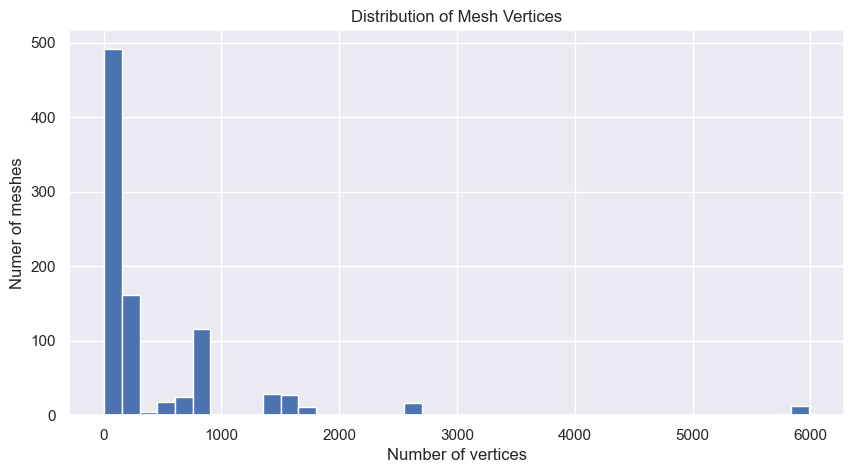

In [32]:
# plot the distribution of mesh vertices
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(mesh_sizes, bins=40)

ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Number of vertices")
ax.set_ylabel("Numer of meshes")
ax.set_title("Distribution of Mesh Vertices")
plt.savefig('Visualizations/Distribution-Mesh-Vertices.png', bbox_inches='tight');

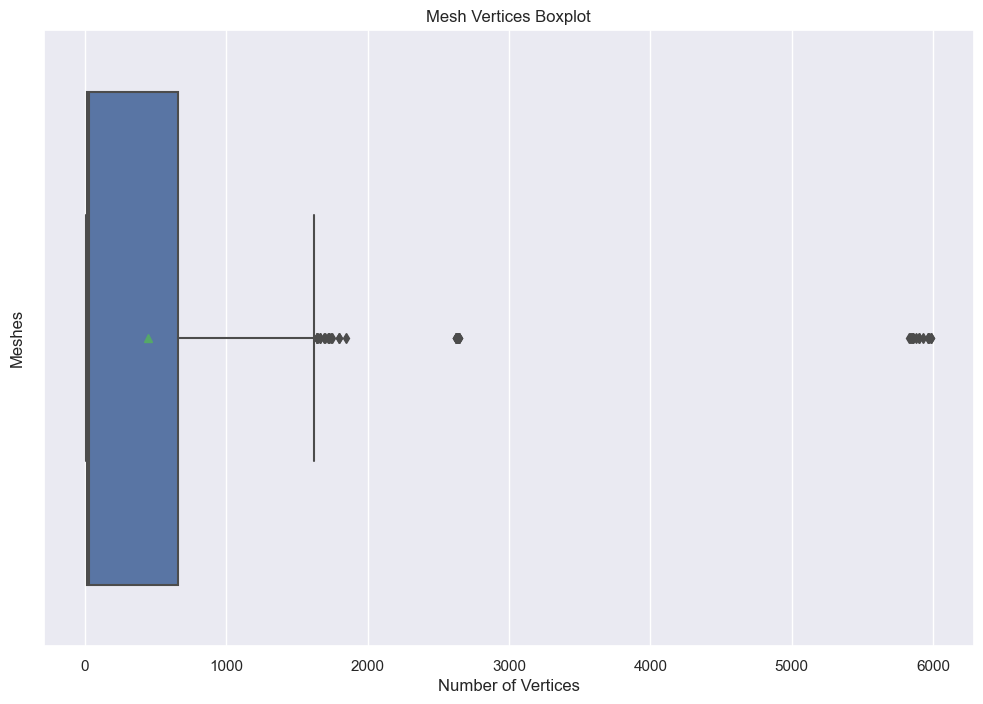

In [33]:
# check mesh sizes for outliers
sns.boxplot(x=mesh_sizes, 
            showmeans=True
).set(
    xlabel='Number of Vertices',
    ylabel='Meshes',
    title='Mesh Vertices Boxplot')
plt.savefig('Visualizations/Mesh-Vertices-Boxplot.png', bbox_inches='tight');

Looks like there are a portion of outliers at the 6000 vertices mark. We certainly dont need all of the vertices to be sampled that high for some outliers. But we wouldnt want to sample it too low that it would destroy the detail in the model. Lets see what the average, median and quartiles come to be.

In [34]:
#  IQR
Q1 = np.percentile(mesh_sizes, 25)
 
Q3 = np.percentile(mesh_sizes, 75)
IQR = Q3 - Q1
 
# Upper bound
upper = Q3+1.5*IQR
# Lower bound
lower = Q1-1.5*IQR 

# print values
print('Average:', np.average(mesh_sizes))
print('Median:', np.median(mesh_sizes))
print('1st Quantile:', Q1)
print('3rd Quantile:', Q3)
print('Lower Bound:', lower)
print('Upper Bound:', upper)

Average: 443.6269146608315
Median: 32.0
1st Quantile: 12.0
3rd Quantile: 656.0
Lower Bound: -954.0
Upper Bound: 1622.0


I would think the upper bound might be the best middle ground between the meshes with the high 6000 vertices (without reducing too much detail) and the meshes with the lowest vertices.

In [35]:
# Save upper bound to num_samples
num_samples=int(upper)

## Mesh Dataset and Dataloader

Ideally the datasets and modeling in this project would have utlized the vertices and faces of the meshes to create models. Due to the lack of sufficient documentation on this type of graph nueral network, we instead decided to just use the vertices of the mesh to analyze each mesh. This architecture is based on the PointNet architecture, originally published in 2017 by Qi, Su, Mo, and Guibas in the paper "PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation"

[PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://arxiv.org/abs/1612.00593)

For our datasets and our dataloaders we used Nikita Raevv's pointnet model as an example to pull from. This model has been adjusted to fit the folder structure created, as well as deal with the file types (objk) files involved. It also pulls functions from pytorch3d to deal with preprocessing.

[Nikitakaraevv-PointNet](https://github.com/nikitakaraevv/pointnet/tree/master)

In [36]:
# Create meshdata function to create a pytorch dataset
class MeshData(Dataset):
    def __init__(self, root_dir, transform=None, num_samples=None):
        '''
        root_dir - relative path to start of folder tree
        The folder structure to use this class needs to be organized as follows:
        train
            category
                file1
                file2
                ...
            category2
                file1
                file2
                ...
            category3
                file1
                file2
                ...
        test
            category
                file1
                file2
                ...
            category2
                file1
                file2
                ...
            category3
                file1
                file2
                ...


        The root_dir needs to be specified as the train, or test folders
        
        transform - assign transforms to the data
        num_samples - specify the number of vertices to sample for each mesh
        
        '''
    
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir + '/' + dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform
        self.num_samples = num_samples
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)
            for file in os.listdir(new_dir):
                if file.endswith('.obj'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)
        


    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        mesh = load_obj(file)
        verts = mesh[0]
        if self.num_samples:
            mesh = Meshes([mesh[0]], [mesh[1][0]])
            mesh_sam = sample_points_from_meshes(mesh, num_samples=num_samples)
            mesh_sam_sq = torch.squeeze(mesh_sam)
            verts_p = mesh_sam_sq
        else:
            verts_p = verts
        if self.transforms:
            verts_p = self.transforms(verts_p)
        return verts_p

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            mesh = self.__preproc__(f)
        return {'mesh': mesh, 
                'category': self.classes[category]}

In [37]:
# Assign train path and validation path
train_path = 'Meshes/1B_FabInc/train'
val_path = 'Meshes/1B_FabInc/val'

# Create train and validation datasets
train_ds = MeshData(train_path, num_samples=num_samples)
val_ds = MeshData(val_path, num_samples=num_samples)

In [38]:
# Create classes dictionary
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'CNC',
 1: 'Metal Band Saw',
 2: 'Metal Laser',
 3: 'Panel Saw',
 4: 'Waterjet'}

In [39]:
# Print various dataset statistics
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(val_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample mesh vertices shape: ', train_ds[0]['mesh'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  730
Valid dataset size:  88
Number of classes:  5
Sample mesh vertices shape:  torch.Size([1622, 3])
Class:  CNC


In [40]:
# Set batch size
batch_size = 32

In [41]:
# Create train and validation dataloader
train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_ds, batch_size=batch_size)

## Assign Class Weights

Lets calculate the weights for each class and then save it in a dictionary to use later.

In [42]:
# total number of items
total = len(df_target2)

In [43]:
# Determine the value counts of each class
Class_total = df_target2['Manufacturing Process'].value_counts().to_dict()
Class_total

{'CNC': 434,
 'Panel Saw': 304,
 'Metal Band Saw': 80,
 'Metal Laser': 78,
 'Waterjet': 18}

In [44]:
# Create dictionary from keys in inv_classes and values in Class_total
Class_total_matched = {}

for key, value in inv_classes.items():
    Class_total_matched[key] = Class_total[value]
    
Class_total_matched

{0: 434, 1: 80, 2: 78, 3: 304, 4: 18}

In [45]:
# Scaling by total/5 to keep the loss to a similar magnitude 
# multiplied by a fraction of the total for each class to determine the class weight.
weight_for_0 = (1 / Class_total_matched[0]) * (total / 5.0)
weight_for_1 = (1 / Class_total_matched[1]) * (total / 5.0)
weight_for_2 = (1 / Class_total_matched[2]) * (total / 5.0)
weight_for_3 = (1 / Class_total_matched[3]) * (total / 5.0)
weight_for_4 = (1 / Class_total_matched[4]) * (total / 5.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4}

print('Weight for class {}: {:.2f}'.format(inv_classes[0], weight_for_0))
print('Weight for class {}: {:.2f}'.format(inv_classes[1], weight_for_1))
print('Weight for class {}: {:.2f}'.format(inv_classes[2], weight_for_2))
print('Weight for class {}: {:.2f}'.format(inv_classes[3], weight_for_3))
print('Weight for class {}: {:.2f}'.format(inv_classes[4], weight_for_4))

Weight for class CNC: 0.42
Weight for class Metal Band Saw: 2.29
Weight for class Metal Laser: 2.34
Weight for class Panel Saw: 0.60
Weight for class Waterjet: 10.16


In [46]:
# convert class weight to tensor for feeding into model
class_weight_tensor = torch.tensor(list(class_weight.values()))
class_weight_tensor

tensor([ 0.4212,  2.2850,  2.3436,  0.6013, 10.1556])

# Modeling

## Base Model

https://github.com/nikitakaraevv/pointnet

We will start with a base model. Given the nature of the mesh data structure, we use the unedited version of the PointNet nueral network from nikitakaraevv to train starting out.

In [47]:
class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, input):
        # input.shape == (bs,n,3)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix


class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 5):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [48]:
# Calculate the model loss
def pointnetloss(weights, outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss(weight = weights)
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [49]:
# set the device. If cuda is available, use cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pointnet = PointNet()
pointnet.to(device);

# Load a pre-trained model if it exists
# pointnet.load_state_dict(torch.load('../input/pointnet-for-3d-object-classification-pytorch/save.pth'))

# set optimizer to the adam optimizer
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.00025)

In [50]:
# Set number of epochs
epochs = 20

In [135]:
# define the train model
def train(model, train_loader, val_loader,  epochs, accuracy_loss, weight_tensor, save_name):
    random.seed = 42
    train_items = train_loader.dataset.__len__()
    batch_size = train_loader.batch_size
    num_batches = math.ceil(train_items/batch_size)
    for epoch in range(epochs): 
        model.train()
        batch_loss = 0.0
        running_loss = 0.0
        train_correct = train_total = 0
        start_time = time.time()
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['mesh'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = model(inputs.transpose(1,2))

            loss = pointnetloss(weight_tensor, outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            batch_loss += loss.item()
            if i % 5 == 4:    # print every 10 mini-batches
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                    (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0


            # Calculate training accuracy
            outputs, __, __ = model(inputs.transpose(1,2))
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()              
        acc = 100. * train_correct / train_total    
        
        model.eval()
        val_correct = val_total = 0

        # validation
        if val_loader:
            val_loss = 0.0
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['mesh'].to(device).float(), data['category'].to(device)
                    outputs, m3x3, m64x64 = model(inputs.transpose(1,2))
                    loss = pointnetloss(weight_tensor, outputs, labels, m3x3, m64x64)

                    outputs, __, __ = model(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    val_loss += loss.item()
            val_acc = 100. * val_correct / val_total


        # save the model
        torch.save(model.state_dict(), save_name)

        # save accuracy and loss to list
        accuracy_loss.append({
           'Epoch': epoch,
           'Loss': batch_loss/num_batches,
           'Accuracy': acc,
           'Val_Accuracy': val_acc,
           'Val_Loss': val_loss
        })
        
        # time and print metrics
        end_time = time.time()
        epoch_time = end_time - start_time
        print('Epoch time:', time.strftime("%Mm:%Ss", time.gmtime(epoch_time)), '- Valid Accuracy: %d %%' % val_acc, '- Accuracy: %d %%' % acc, '- Valid Loss: %.3f' % val_loss )

In [52]:
# set accuracy_loss list and save_name
accuracy_loss = []
save_name0 = 'Pytorch_Model_Save/Base_Model_0.pth'

In [53]:
# run the training model
train(pointnet, train_loader, val_loader, epochs, accuracy_loss, class_weight_tensor, save_name0)

[Epoch: 1, Batch:    5 /   23], loss: 0.819
[Epoch: 1, Batch:   10 /   23], loss: 0.767
[Epoch: 1, Batch:   15 /   23], loss: 0.723
[Epoch: 1, Batch:   20 /   23], loss: 0.724
Epoch time: 01m:30s - Valid Accuracy: 35 % - Accuracy: 42 % - Valid Loss: 4.158
[Epoch: 2, Batch:    5 /   23], loss: 0.641
[Epoch: 2, Batch:   10 /   23], loss: 0.646
[Epoch: 2, Batch:   15 /   23], loss: 0.576
[Epoch: 2, Batch:   20 /   23], loss: 0.638
Epoch time: 01m:30s - Valid Accuracy: 48 % - Accuracy: 50 % - Valid Loss: 3.369
[Epoch: 3, Batch:    5 /   23], loss: 0.587
[Epoch: 3, Batch:   10 /   23], loss: 0.504
[Epoch: 3, Batch:   15 /   23], loss: 0.476
[Epoch: 3, Batch:   20 /   23], loss: 0.487
Epoch time: 01m:30s - Valid Accuracy: 57 % - Accuracy: 59 % - Valid Loss: 3.541
[Epoch: 4, Batch:    5 /   23], loss: 0.532
[Epoch: 4, Batch:   10 /   23], loss: 0.531
[Epoch: 4, Batch:   15 /   23], loss: 0.438
[Epoch: 4, Batch:   20 /   23], loss: 0.598
Epoch time: 01m:30s - Valid Accuracy: 68 % - Accuracy: 6

In [54]:
# Store accuracy and loss values in dataframe with Epoch as index
accuracy_loss_df = pd.DataFrame.from_records(accuracy_loss)
accuracy_loss_df = accuracy_loss_df.set_index('Epoch')

In [55]:
# reload last state of the model from training
pointnet.load_state_dict(torch.load(save_name0))
pointnet.eval();

In [56]:
# evaluate the model to get predictions and true labels
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        print('Batch [%4d / %4d]' % (i+1, len(val_loader)))
        
        inputs, labels = data['mesh'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

Batch [   1 /    3]
Batch [   2 /    3]
Batch [   3 /    3]


In [57]:
# calculate all classes
classes = list(train_ds.classes.keys())

In [58]:
# Define a function to show classification report and confusion matrix
def show_classification_report_and_confusion_matrix(model, 
                                                    y_pred,
                                                    y_test,
                                                    classes, 
                                                    cm_cmap, 
                                                    cr_cmap, 
                                                    cm_title, 
                                                    cr_title,
                                                    cm_save,
                                                    cr_save):
    

    
    # Display a confusion matrix using the test and predicted values
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap = cm_cmap)
    disp.ax_.set_title(cm_title)
    disp.ax_.xaxis.labelpad = 20
    plt.grid(False)
    plt.savefig(cm_save, bbox_inches='tight')   
    plt.show()

    
    # Create dataframe of classification report
    df = pd.DataFrame(classification_report(y_test, 
                                        y_pred, 
                                        target_names=classes, 
                                        digits=2,
                                        output_dict=True)).T
    
    # Create fig and ax for classification report
    fig, ax = plt.subplots()

    # Mask all classification report cells except class metric cells and create heatmap
    mask = np.zeros((df.shape))
    mask[:, -1] = True
    mask[5:8, :] = True
    ax = sns.heatmap(pd.DataFrame(df), mask=mask, vmin=0, vmax=1, cmap=cr_cmap, annot=True, fmt='.2f')

    # Mask all classification report cells except class support cells and create heatmap
    mask = np.zeros(df.shape)
    mask[:,:3] = True 
    mask[6:8, :] = True
    ax = sns.heatmap(df, mask=mask, annot=True, cmap='Greys', cbar=False, fmt='.2f') 

    # Mask all classification report cells except macro avg and weighted avg rows and create heatmap
    mask = np.zeros(df.shape)
    mask[0:6, :] = True
    ax = sns.heatmap(df, mask=mask, annot=True, cmap='Greys', cbar=False, fmt='.2f') 

    # Specify classification report title and ytick direction
    plt.title(cr_title)
    plt.yticks(rotation = 0);
    plt.savefig(cr_save, bbox_inches='tight')  

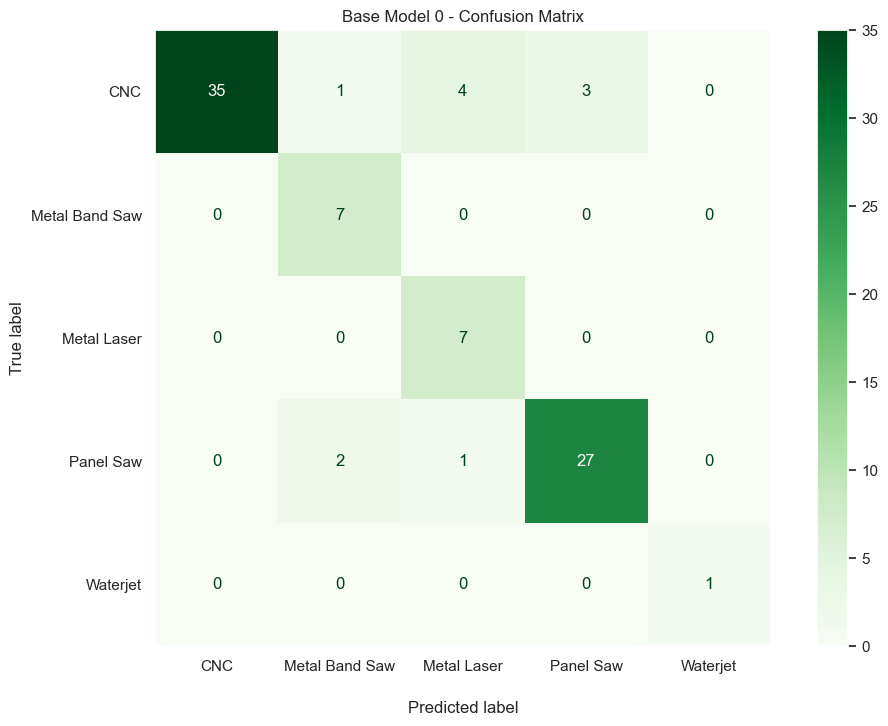

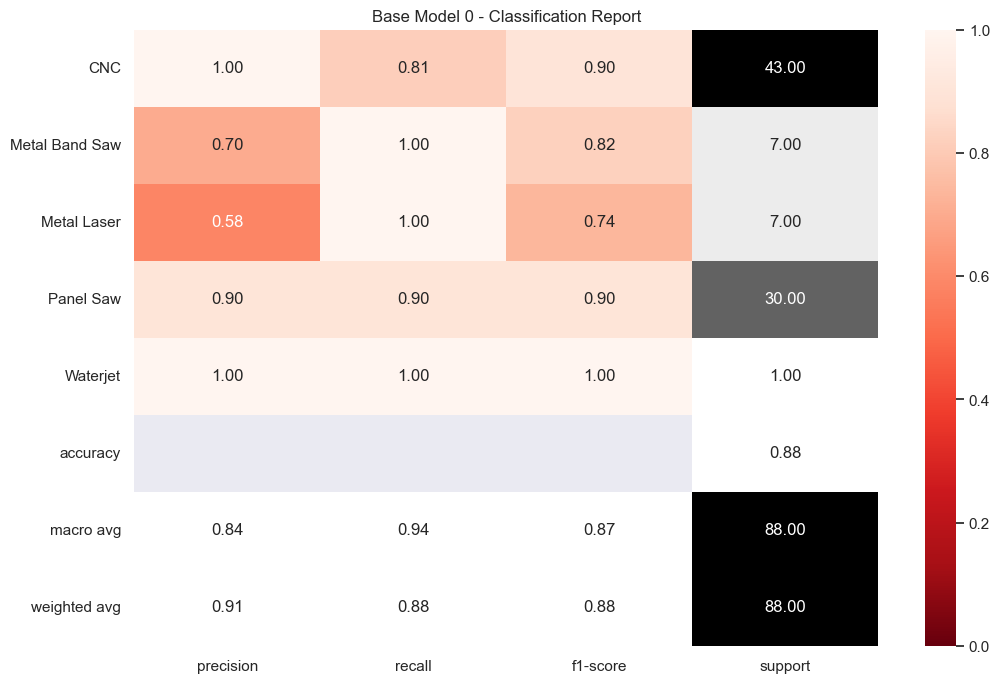

In [59]:
# create classification report and confuision matrix for first base model
show_classification_report_and_confusion_matrix(pointnet, 
                                                all_preds, 
                                                all_labels, 
                                                classes,
                                                'Greens', 
                                                'Reds_r', 
                                                'Base Model 0 - Confusion Matrix', 
                                                'Base Model 0 - Classification Report',
                                                'Visualizations/0-Confusion_Matrix.png',
                                                'Visualizations/0-Classification_Report.png')

In [60]:
# Define a function to show the graph of train loss vs validation loss and the graph of train accuracy vs validation accuracy
def visualize_training_results(history, loss_title, acc_title, loss_save, acc_save):
    plt.figure()
    plt.plot(history['Val_Loss'])
    plt.plot(history['Loss'])
    plt.legend(['Val_Loss', 'Loss'])
    plt.title(loss_title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(loss_save, bbox_inches='tight')   
    plt.show()
    
    plt.figure()
    plt.plot(history['Val_Accuracy'])
    plt.plot(history['Accuracy'])
    plt.legend(['Val_Accuracy', 'Accuracy'])
    plt.title(acc_title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig(acc_save, bbox_inches='tight')   
    plt.show()

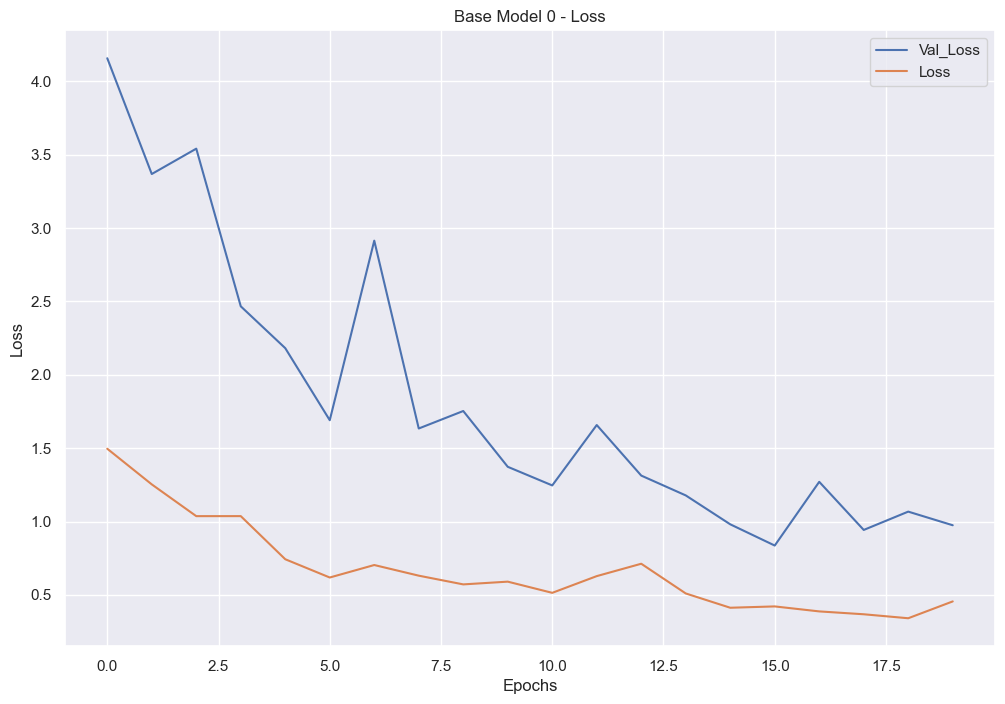

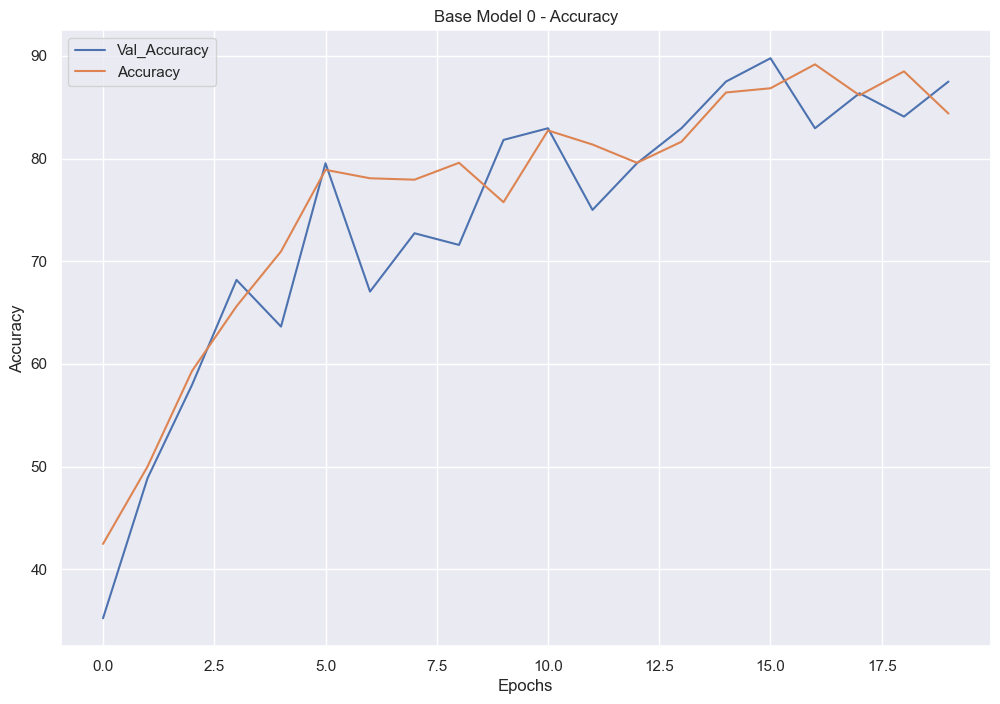

In [61]:
# Plot loss and accuracy
visualize_training_results(accuracy_loss_df,
                          'Base Model 0 - Loss',
                          'Base Model 0 - Accuracy',
                          'Visualizations/0-Loss.png',
                          'Visualizations/0-Accuracy.png',)

We are starting pretty well with the first base model without any adjustments. Our precision and f1-score is around 85%/90%

## Model 1

For the next model, we will take the train dataset, augment some of the data, and feed it back into the same model. We will also manage the class imbalance by applying our class weights to the loss function within our model

In [62]:
# Create classes for each type of transform

class RandRotation_z(object):
    def __call__(self, mesh_verts):
        assert len(mesh_verts.shape)==2
        
        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_mesh_verts = rot_matrix.dot(mesh_verts.T).T
        return  rot_mesh_verts

# class RandTranslate(object):
#     def __call__(self, mesh_verts):
#         assert len(mesh_verts.shape)==2
        
#         random.seed(10)
#         scalar = random.randrange(1, 100, 1)
#         trans_vector = np.array([random.random(), random.random(), random.random()])
#         trans_vector_scaled = trans_vector *scalar
#         trans_matrix = torch.from_numpy(trans_vector_scaled) + verts_p
#         return trans_matrix    

class RandomNoise(object):
    def __call__(self, mesh_verts):
        assert len(mesh_verts.shape)==2
        np.random.seed(seed=10)
        noise = np.random.normal(0, 0.01, (mesh_verts.shape))
    
        noisy_mesh_verts = mesh_verts + noise
        return  noisy_mesh_verts

class Normalize(object):
    def __call__(self, mesh_verts):
        assert len(mesh_verts.shape)==2
        
        norm_mesh_verts = mesh_verts - torch.mean(mesh_verts, axis=0)
        norm_mesh_verts /= np.max(np.linalg.norm(norm_mesh_verts, axis=1))


        return  norm_mesh_verts

Lets take a sample file and run it through all of the augmentation classes created to see what comes out

In [63]:
# define a plot function
def plot_mesh_verts(mesh_verts):
    fig=plt.figure(figsize=(8,8))
    ax = plt.subplot(1,1,1, projection='3d')
    ax.scatter(mesh_verts[:,0], mesh_verts[:,1], mesh_verts[:,2])
    plt.axis('equal');

In [64]:
# define example file
file = r'C:\Users\Tim\Documents\Flatiron\Capstone\Part-Processing\Meshes\1A_FabInc_OBJ_Class\CNC\Cab1-01 - Cab1-04-1.obj'

# load file and store vertices in array
mesh = load_obj(file)
verts = mesh[0]
mesh = Meshes([mesh[0]], [mesh[1][0]])
mesh_sam = sample_points_from_meshes(mesh, num_samples=num_samples)
mesh_sam_sq = torch.squeeze(mesh_sam)
verts_p = mesh_sam_sq
verts_p

tensor([[11.2385, 30.1500,  3.1781],
        [10.8396, 29.6500,  0.1245],
        [ 9.8691, 29.6971,  5.1200],
        ...,
        [ 3.4076, 30.1500,  0.4042],
        [ 4.7508, 30.1011,  5.1200],
        [ 5.8494, 29.4000,  4.7325]])

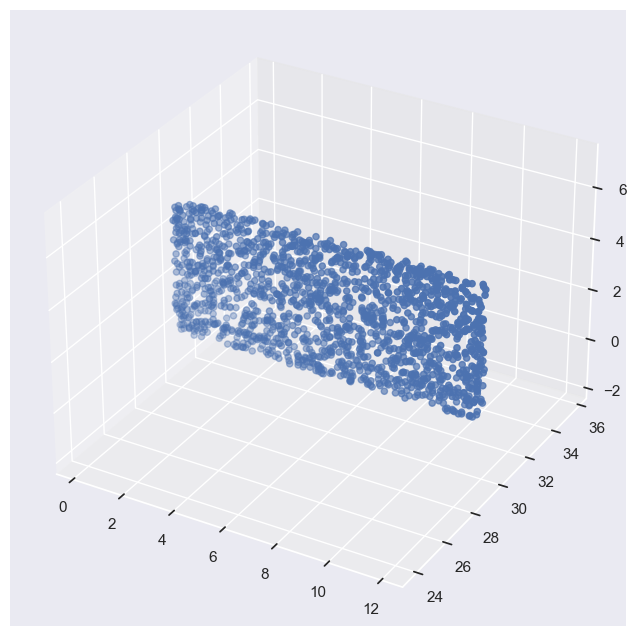

In [65]:
plot_mesh_verts(verts_p)

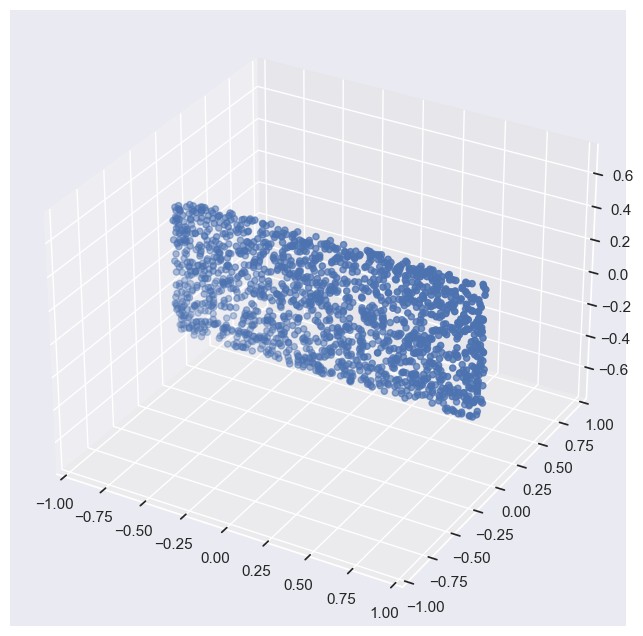

In [66]:
verts_p_aug = Normalize()(verts_p)
plot_mesh_verts(verts_p_aug)

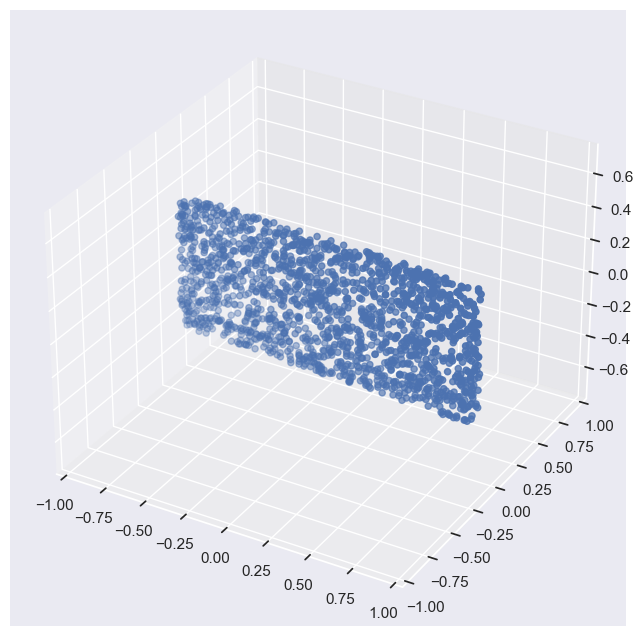

In [67]:
verts_p_aug = RandRotation_z()(verts_p_aug)
plot_mesh_verts(verts_p_aug)

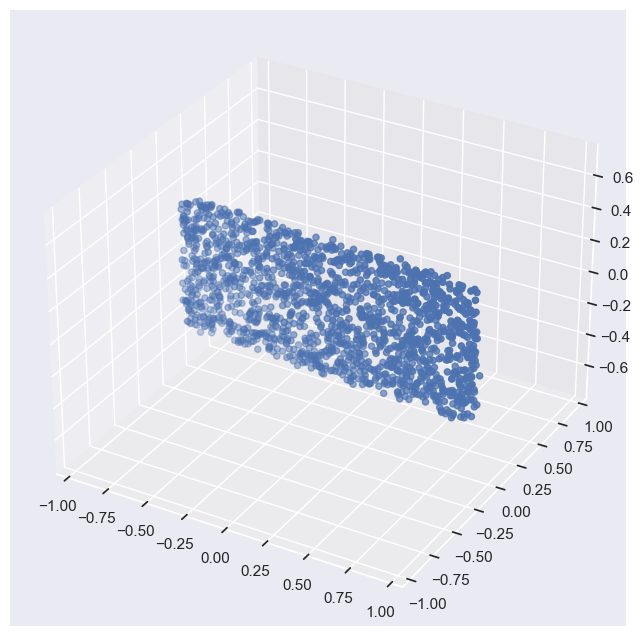

In [68]:
verts_p_aug = RandomNoise()(verts_p_aug)
plot_mesh_verts(verts_p_aug)

In [69]:
# Group all the model transforms into a function
def Train_transforms():
    return transforms.Compose([
                                Normalize(),
                                RandRotation_z(),
                              ])

In [70]:
# Create train dataset
train_ds2 = MeshData(train_path, transform=Train_transforms(), num_samples=num_samples)
val_ds2 = MeshData(val_path, transform=Train_transforms(), num_samples=num_samples)

In [71]:
train_loader2 = DataLoader(dataset=train_ds2, batch_size=batch_size, shuffle=True)
val_loader2 = DataLoader(dataset=val_ds2, batch_size=batch_size, shuffle=True)

In [72]:
pointnet2 = PointNet()
pointnet2.to(device);

# Load a pre-trained model if it exists
# pointnet.load_state_dict(torch.load('Pytorch_Model_Save/Model_1.pth'))

# set optimizer to the adam optimizer
optimizer = torch.optim.Adam(pointnet2.parameters(), lr=0.001)

In [73]:
epochs = 20

In [74]:
# run the training model
accuracy_loss2 = []
save_name1 = 'Pytorch_Model_Save/Model_1.pth'
train(pointnet2, train_loader2, val_loader2, epochs, accuracy_loss2, class_weight_tensor, save_name1)

[Epoch: 1, Batch:    5 /   23], loss: 0.829
[Epoch: 1, Batch:   10 /   23], loss: 0.789
[Epoch: 1, Batch:   15 /   23], loss: 0.905
[Epoch: 1, Batch:   20 /   23], loss: 0.784
Epoch time: 01m:29s - Valid Accuracy: 37 % - Accuracy: 31 % - Valid Loss: 4.808
[Epoch: 2, Batch:    5 /   23], loss: 0.886
[Epoch: 2, Batch:   10 /   23], loss: 0.753
[Epoch: 2, Batch:   15 /   23], loss: 0.783
[Epoch: 2, Batch:   20 /   23], loss: 0.754
Epoch time: 01m:29s - Valid Accuracy: 47 % - Accuracy: 44 % - Valid Loss: 4.147
[Epoch: 3, Batch:    5 /   23], loss: 0.712
[Epoch: 3, Batch:   10 /   23], loss: 0.758
[Epoch: 3, Batch:   15 /   23], loss: 0.710
[Epoch: 3, Batch:   20 /   23], loss: 0.715
Epoch time: 01m:29s - Valid Accuracy: 43 % - Accuracy: 46 % - Valid Loss: 3.869
[Epoch: 4, Batch:    5 /   23], loss: 0.743
[Epoch: 4, Batch:   10 /   23], loss: 0.660
[Epoch: 4, Batch:   15 /   23], loss: 0.628
[Epoch: 4, Batch:   20 /   23], loss: 0.738
Epoch time: 01m:29s - Valid Accuracy: 59 % - Accuracy: 5

In [75]:
# Set accuracy and loss
accuracy_loss_df2 = pd.DataFrame.from_records(accuracy_loss2)
accuracy_loss_df2 = accuracy_loss_df2.set_index('Epoch')

In [76]:
# reload last state of the model from training
pointnet2.load_state_dict(torch.load(save_name1))
pointnet2.eval();

In [77]:
# evaluate the model to get predictions and true labels
all_preds2 = []
all_labels2 = []
with torch.no_grad():
    for i, data in enumerate(val_loader2):
        print('Batch [%4d / %4d]' % (i+1, len(val_loader2)))
        
        inputs, labels = data['mesh'].float(), data['category']
        outputs, __, __ = pointnet2(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds2 += list(preds.numpy())
        all_labels2 += list(labels.numpy())

Batch [   1 /    3]
Batch [   2 /    3]
Batch [   3 /    3]


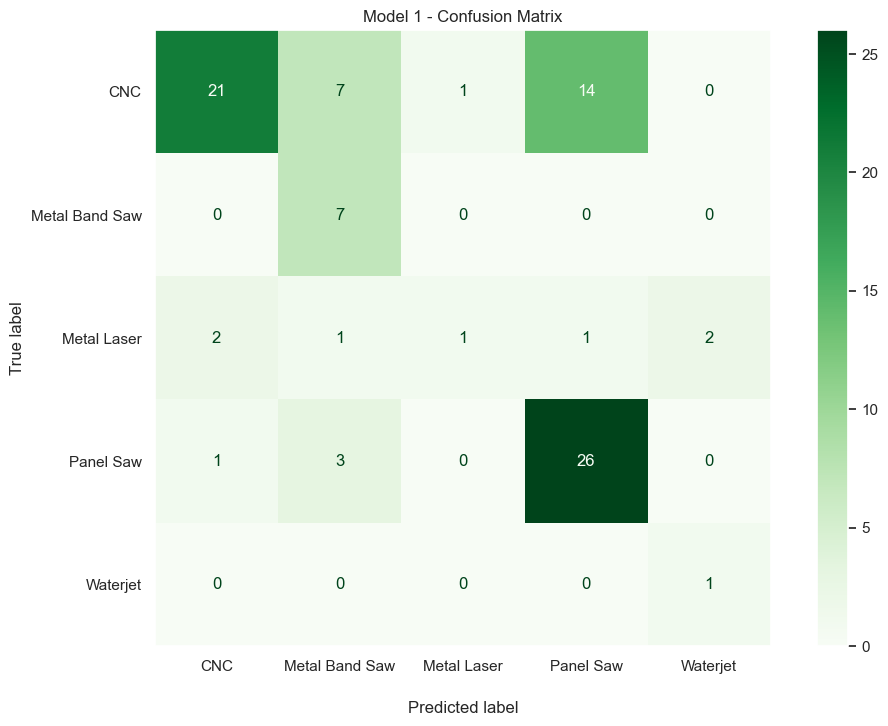

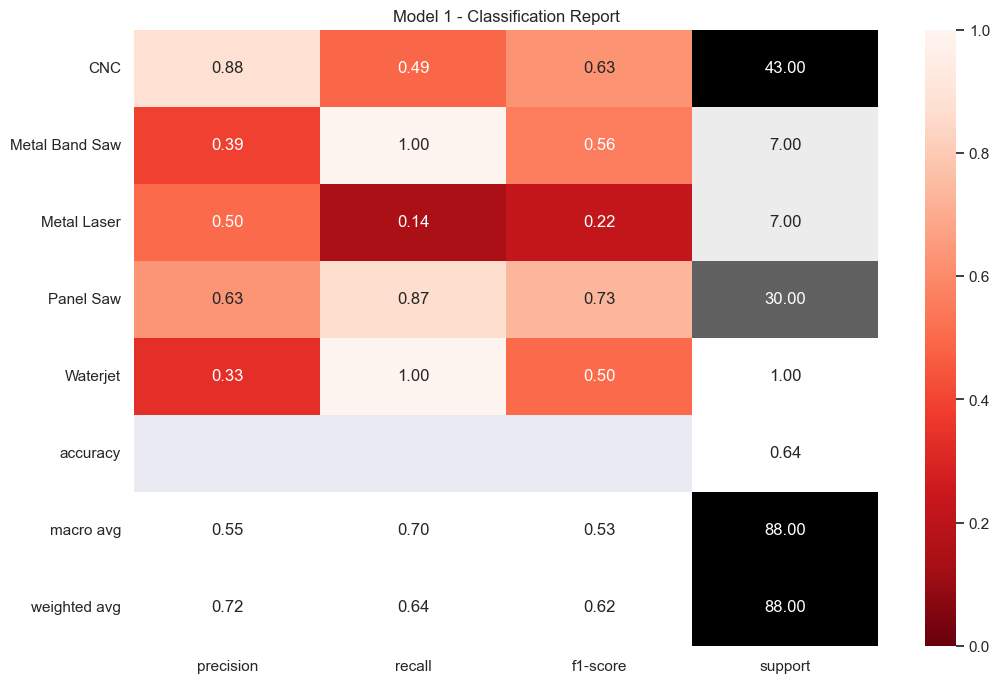

In [78]:
# create classification report and confuision matrix for first base model
show_classification_report_and_confusion_matrix(pointnet2, 
                                                all_preds2, 
                                                all_labels2, 
                                                classes,
                                                'Greens', 
                                                'Reds_r', 
                                                'Model 1 - Confusion Matrix', 
                                                'Model 1 - Classification Report',
                                                'Visualizations/1-Confusion_Matrix.png',
                                                'Visualizations/1-Classification_Report.png')

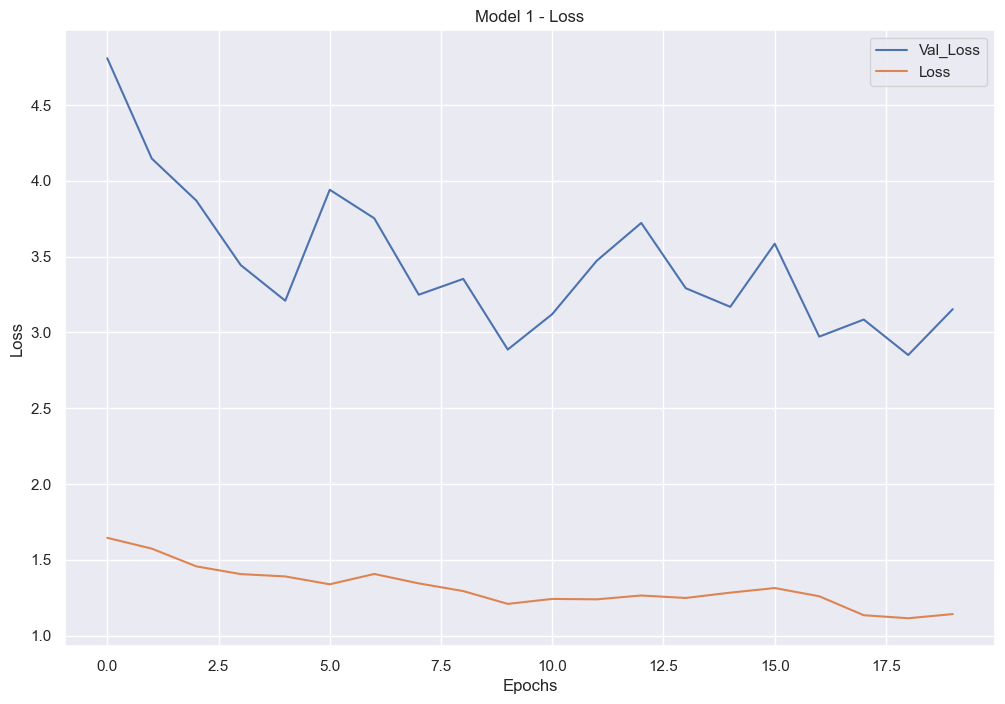

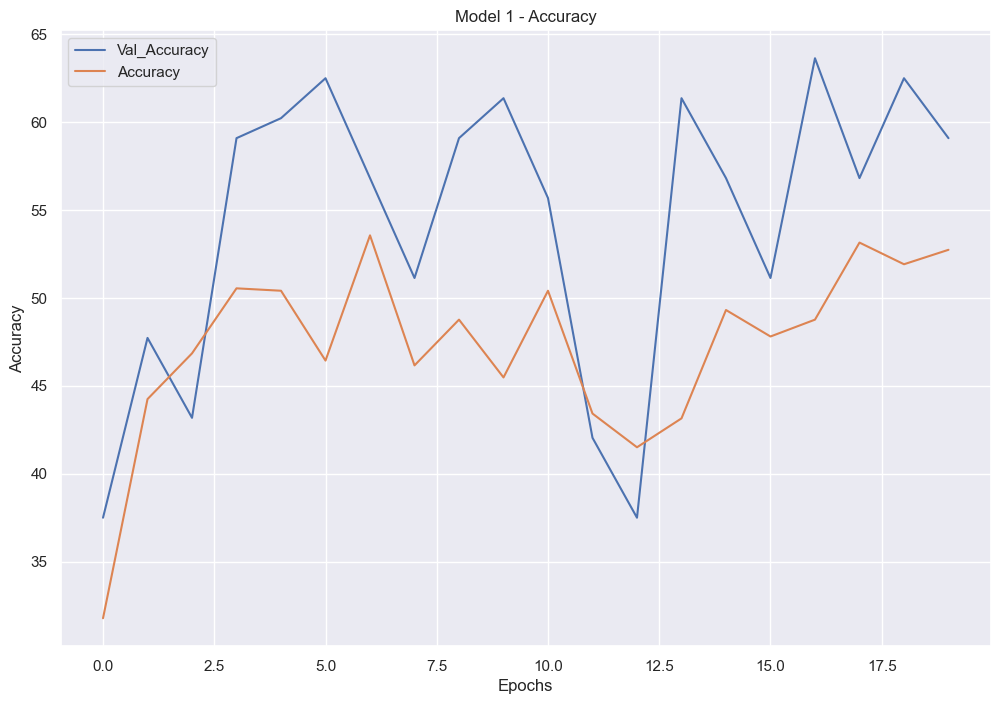

In [79]:
visualize_training_results(accuracy_loss_df2,
                          'Model 1 - Loss',
                          'Model 1 - Accuracy',
                          'Visualizations/1-Loss.png',
                          'Visualizations/1-Accuracy.png')

So model 1 performed a little bit worse than our base model, and understandably so considering that data augmentation was performed on this model. Though this augmentation will allow the model to better generalize in predictions on items in the future. The precision and F1-score for the CNC class is slightly lower than the base model though it doesnt come too far behind.

The validation accuracy seems to be erratically improving between epochs, most likely due to the larger learning rate we assigned to the optimizer. We will reduce the rate back again for the next model

## Model 2

We add a convolution layer to each class and increased the amount of maximum channels to 1622 (which is the same amount as the vertices we have set for the meshes). The original PointNet paper had sampled the meshes at 1024, which is also the same amount of channels that their nueral network was brought to. 

We will also add a additional dropout layer to prevent overfitting. In our last model, we also had a initial problem with loss, so changing our optimizer to AdamW should start to keep that under control

In [80]:
class Tnet3(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.conv4 = nn.Conv1d(1024,1622,1)
        self.fc1 = nn.Linear(1622,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,256)
        self.fc4 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(1622)
        self.bn5 = nn.BatchNorm1d(1024)
        self.bn6 = nn.BatchNorm1d(512)
        self.bn7 = nn.BatchNorm1d(256)


    def forward(self, input):
        # input.shape == (bs,n,3)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        xb = F.relu(self.bn4(self.conv4(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn5(self.fc1(flat)))
        xb = F.relu(self.bn6(self.fc2(xb)))
        xb = F.relu(self.bn7(self.fc3(xb)))


        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc4(xb).view(-1,self.k,self.k) + init
        return matrix


class Transform3(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet3(k=3)
        self.feature_transform = Tnet3(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.conv4 = nn.Conv1d(1024,1622,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(1622)

    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        xb = self.bn4(self.conv4(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet3(nn.Module):
    def __init__(self, classes = 5):
        super().__init__()
        self.transform = Transform3()
        self.fc1 = nn.Linear(1622, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, classes)
        
        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout1(self.fc2(xb))))
        xb = F.relu(self.bn3(self.dropout2(self.fc3(xb))))
        output = self.fc4(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [81]:
# set the device. If cuda is available, use cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pointnet3 = PointNet3()
pointnet3.to(device);

# Load a pre-trained model if it exists
# pointnet.load_state_dict(torch.load('../input/pointnet-for-3d-object-classification-pytorch/save.pth'))

# set optimizer to the adam optimizer
optimizer = torch.optim.Adam(pointnet3.parameters(), lr=0.00025)

In [82]:
# Create train dataset
train_ds3 = MeshData(train_path, transform=Train_transforms(), num_samples=num_samples)
val_ds3 = MeshData(val_path, transform=Train_transforms(), num_samples=num_samples)

In [83]:
train_loader3 = DataLoader(dataset=train_ds3, batch_size=batch_size, shuffle=True)
val_loader3 = DataLoader(dataset=val_ds3, batch_size=batch_size, shuffle=True)

In [84]:
# Set number of epochs
epochs = 20

In [85]:
# run the training model
accuracy_loss3 = []
save_name3 = 'Pytorch_Model_Save/Model_2.pth'
train(pointnet3, train_loader3, val_loader3, epochs, accuracy_loss3, class_weight_tensor, save_name3)

[Epoch: 1, Batch:    5 /   23], loss: 0.857
[Epoch: 1, Batch:   10 /   23], loss: 0.807
[Epoch: 1, Batch:   15 /   23], loss: 0.811
[Epoch: 1, Batch:   20 /   23], loss: 0.765
Epoch time: 05m:52s - Valid Accuracy: 38 % - Accuracy: 29 % - Valid Loss: 4.751
[Epoch: 2, Batch:    5 /   23], loss: 0.793
[Epoch: 2, Batch:   10 /   23], loss: 0.723
[Epoch: 2, Batch:   15 /   23], loss: 0.763
[Epoch: 2, Batch:   20 /   23], loss: 0.782
Epoch time: 05m:38s - Valid Accuracy: 43 % - Accuracy: 36 % - Valid Loss: 4.235
[Epoch: 3, Batch:    5 /   23], loss: 0.775
[Epoch: 3, Batch:   10 /   23], loss: 0.715
[Epoch: 3, Batch:   15 /   23], loss: 0.694
[Epoch: 3, Batch:   20 /   23], loss: 0.743
Epoch time: 05m:42s - Valid Accuracy: 59 % - Accuracy: 45 % - Valid Loss: 4.117
[Epoch: 4, Batch:    5 /   23], loss: 0.761
[Epoch: 4, Batch:   10 /   23], loss: 0.687
[Epoch: 4, Batch:   15 /   23], loss: 0.715
[Epoch: 4, Batch:   20 /   23], loss: 0.683
Epoch time: 05m:42s - Valid Accuracy: 38 % - Accuracy: 4

In [86]:
# Set accuracy and loss dataframe
accuracy_loss_df3 = pd.DataFrame.from_records(accuracy_loss3)
accuracy_loss_df3 = accuracy_loss_df3.set_index('Epoch')

In [87]:
# load model and evaluate
current_model_dict = pointnet3.state_dict()
loaded_state_dict = torch.load(save_name3)
new_state_dict={k:v if v.size()==current_model_dict[k].size()  else  current_model_dict[k] for k,v in zip(current_model_dict.keys(), loaded_state_dict.values())}
pointnet3.load_state_dict(new_state_dict, strict=False)
pointnet3.eval();

In [88]:
# evaluate the model to get predictions and true labels
all_preds3 = []
all_labels3 = []
with torch.no_grad():
    for i, data in enumerate(val_loader3):
        print('Batch [%4d / %4d]' % (i+1, len(val_loader3)))
        
        inputs, labels = data['mesh'].float(), data['category']
        outputs, __, __ = pointnet3(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds3 += list(preds.numpy())
        all_labels3 += list(labels.numpy())

Batch [   1 /    3]
Batch [   2 /    3]
Batch [   3 /    3]


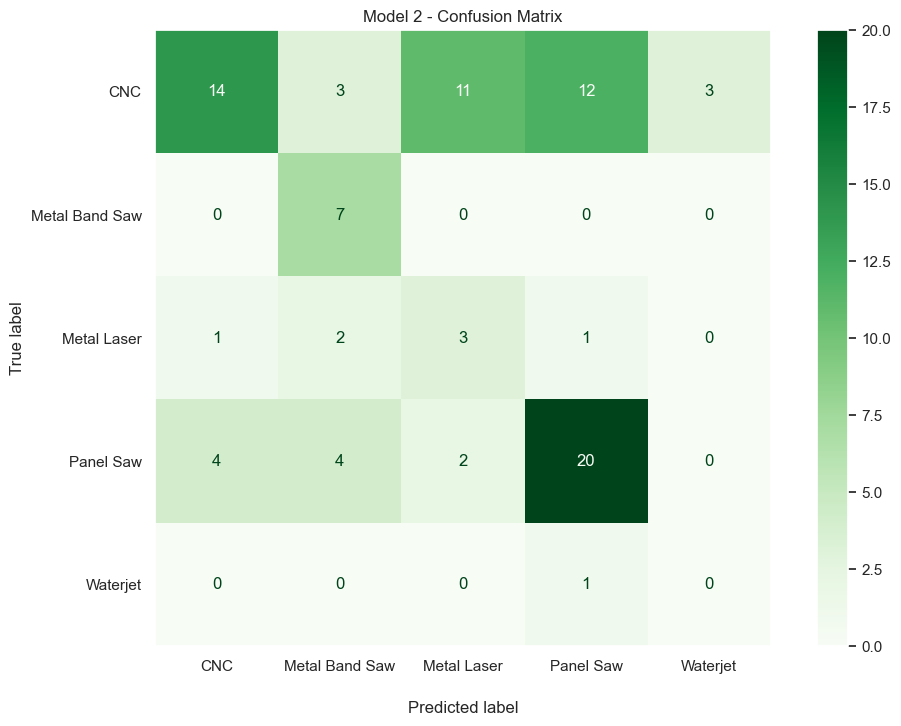

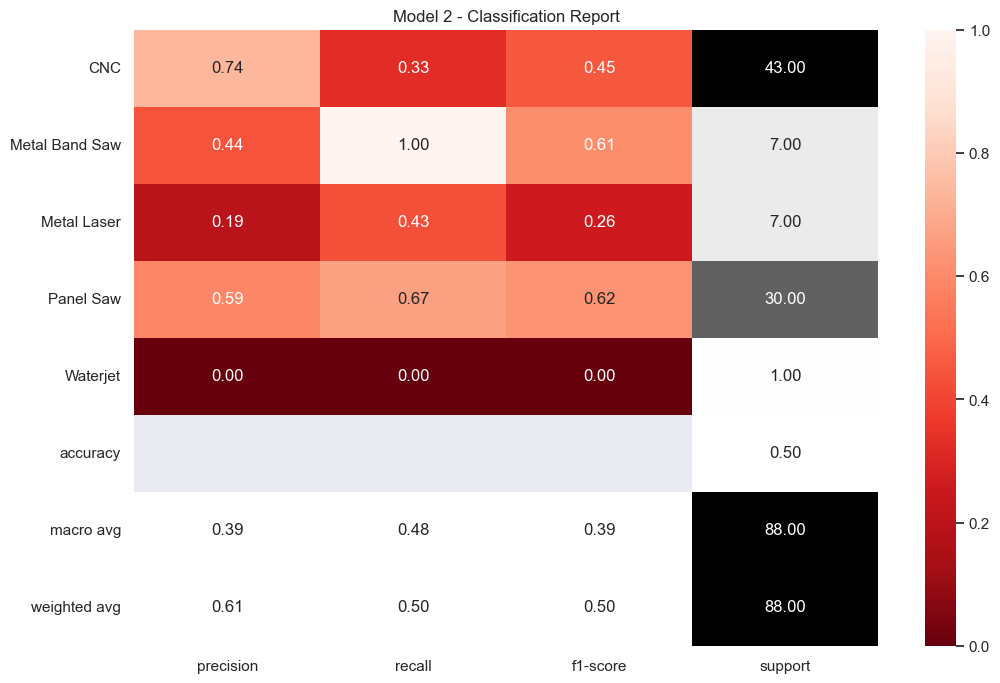

In [89]:
# create classification report and confuision matrix for first base model
show_classification_report_and_confusion_matrix(pointnet3, 
                                                all_preds3, 
                                                all_labels3, 
                                                classes,
                                                'Greens', 
                                                'Reds_r', 
                                                'Model 2 - Confusion Matrix', 
                                                'Model 2 - Classification Report',
                                                'Visualizations/2-Confusion_Matrix.png',
                                                'Visualizations/2-Classification_Report.png')

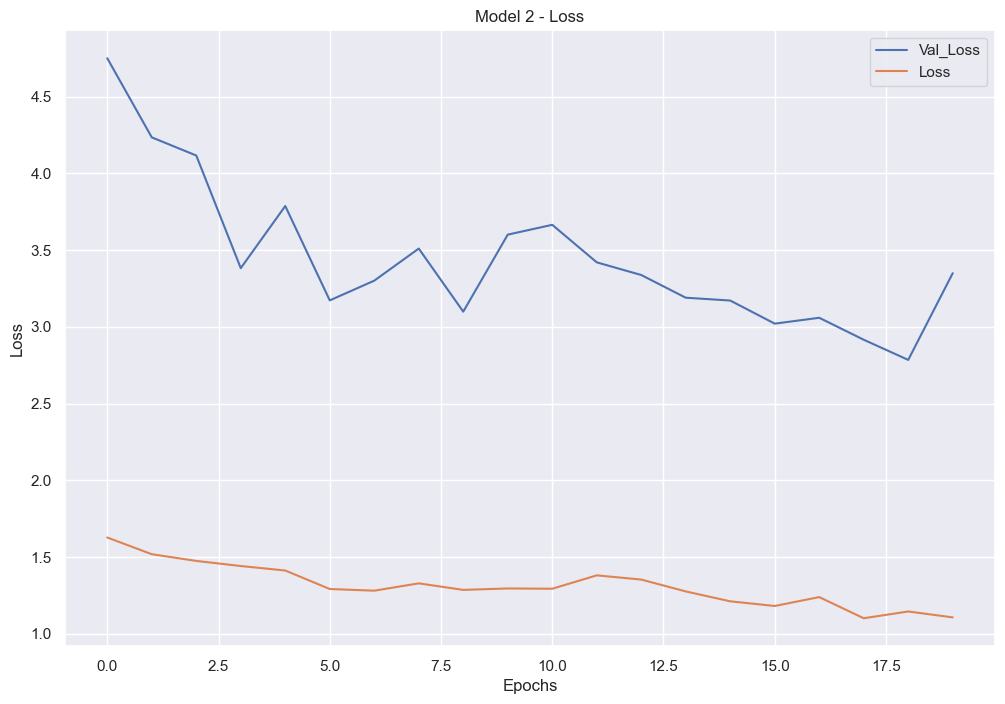

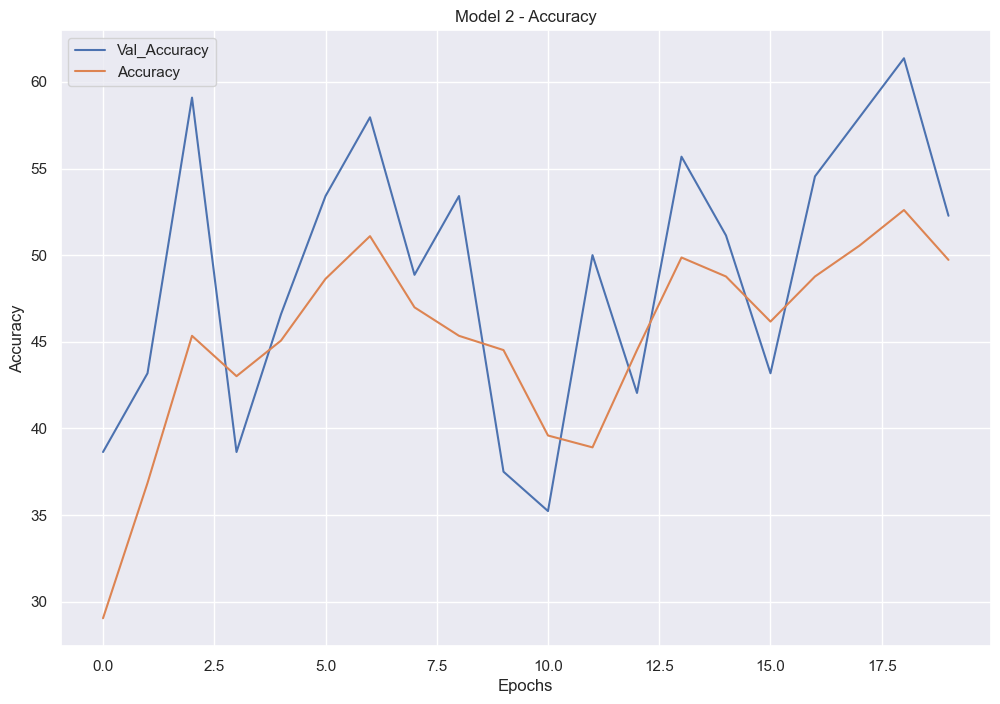

In [90]:
visualize_training_results(accuracy_loss_df3,
                          'Model 2 - Loss',
                          'Model 2 - Accuracy',
                          'Visualizations/2-Loss.png',
                          'Visualizations/2-Accuracy.png')

This model looks like the metrics actually performed worse across the board. Even the CNC class received worse scores in precision and F1 score. Maybe we will tweak a few values to see if it helps.

## Model 3

We will make one more model by tweaking the optimizer to an AdamW optimizer, adjusting the learning rate to a lower number, and lower the batch size to see if this will improve the model's performance.

In [91]:
# set the device. If cuda is available, use cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pointnet4 = PointNet3()
pointnet4.to(device);

# Load a pre-trained model if it exists
# pointnet.load_state_dict(torch.load('../input/pointnet-for-3d-object-classification-pytorch/save.pth'))

# set optimizer to the adam optimizer
optimizer = torch.optim.AdamW(pointnet4.parameters(), lr=0.00025)

In [92]:
# Create train dataset
train_ds4 = MeshData(train_path, transform=Train_transforms(), num_samples=num_samples)
val_ds4 = MeshData(val_path, transform=Train_transforms(), num_samples=num_samples)

In [93]:
# assign new batch size
batch_size = 8

In [94]:
# Create data loaders
train_loader4 = DataLoader(dataset=train_ds4, batch_size=batch_size, shuffle=True)
val_loader4 = DataLoader(dataset=val_ds4, batch_size=batch_size, shuffle=True)

In [95]:
# Set number of epochs
epochs = 20

In [96]:
# run the training model
accuracy_loss4 = []
save_name4 = 'Pytorch_Model_Save/Model_3.pth'
train(pointnet4, train_loader4, val_loader4, epochs, accuracy_loss4, class_weight_tensor, save_name4)

[Epoch: 1, Batch:    5 /   92], loss: 0.856
[Epoch: 1, Batch:   10 /   92], loss: 0.853
[Epoch: 1, Batch:   15 /   92], loss: 0.808
[Epoch: 1, Batch:   20 /   92], loss: 0.740
[Epoch: 1, Batch:   25 /   92], loss: 0.892
[Epoch: 1, Batch:   30 /   92], loss: 0.804
[Epoch: 1, Batch:   35 /   92], loss: 0.746
[Epoch: 1, Batch:   40 /   92], loss: 0.706
[Epoch: 1, Batch:   45 /   92], loss: 0.728
[Epoch: 1, Batch:   50 /   92], loss: 0.717
[Epoch: 1, Batch:   55 /   92], loss: 0.769
[Epoch: 1, Batch:   60 /   92], loss: 0.780
[Epoch: 1, Batch:   65 /   92], loss: 0.818
[Epoch: 1, Batch:   70 /   92], loss: 0.763
[Epoch: 1, Batch:   75 /   92], loss: 0.836
[Epoch: 1, Batch:   80 /   92], loss: 0.709
[Epoch: 1, Batch:   85 /   92], loss: 0.680
[Epoch: 1, Batch:   90 /   92], loss: 0.816
Epoch time: 05m:46s - Valid Accuracy: 37 % - Accuracy: 43 % - Valid Loss: 16.279
[Epoch: 2, Batch:    5 /   92], loss: 0.759
[Epoch: 2, Batch:   10 /   92], loss: 0.689
[Epoch: 2, Batch:   15 /   92], loss: 0

In [97]:
accuracy_loss_df4 = pd.DataFrame.from_records(accuracy_loss4)
accuracy_loss_df4 = accuracy_loss_df4.set_index('Epoch')

In [98]:
pointnet4.load_state_dict(torch.load(save_name4))
pointnet4.eval();

In [99]:
# evaluate the model to get predictions and true labels
all_preds4 = []
all_labels4 = []
with torch.no_grad():
    for i, data in enumerate(val_loader4):
        print('Batch [%4d / %4d]' % (i+1, len(val_loader4)))
        
        inputs, labels = data['mesh'].float(), data['category']
        outputs, __, __ = pointnet4(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds4 += list(preds.numpy())
        all_labels4 += list(labels.numpy())

Batch [   1 /   11]
Batch [   2 /   11]
Batch [   3 /   11]
Batch [   4 /   11]
Batch [   5 /   11]
Batch [   6 /   11]
Batch [   7 /   11]
Batch [   8 /   11]
Batch [   9 /   11]
Batch [  10 /   11]
Batch [  11 /   11]


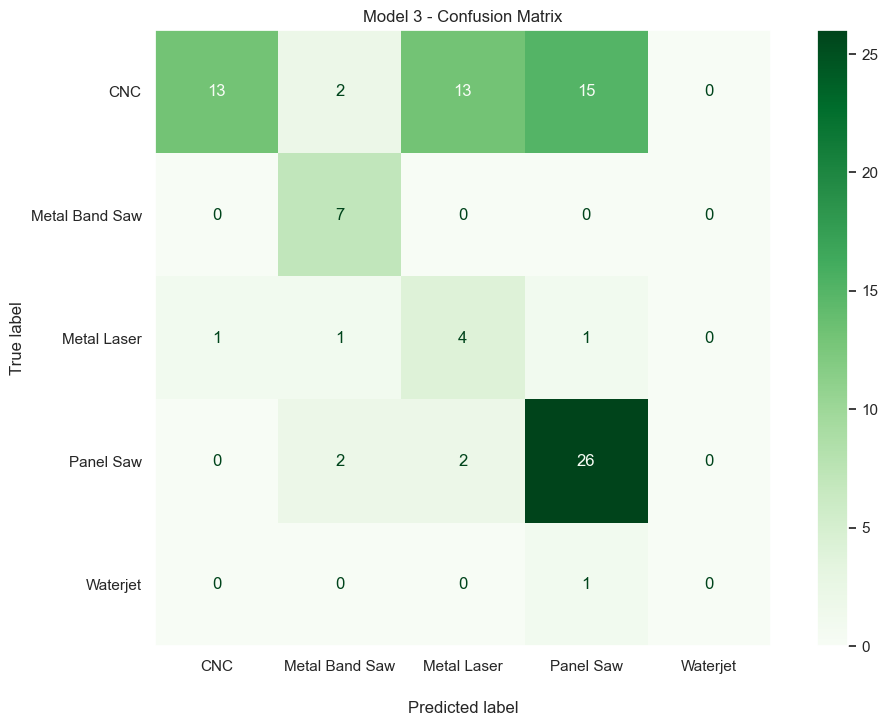

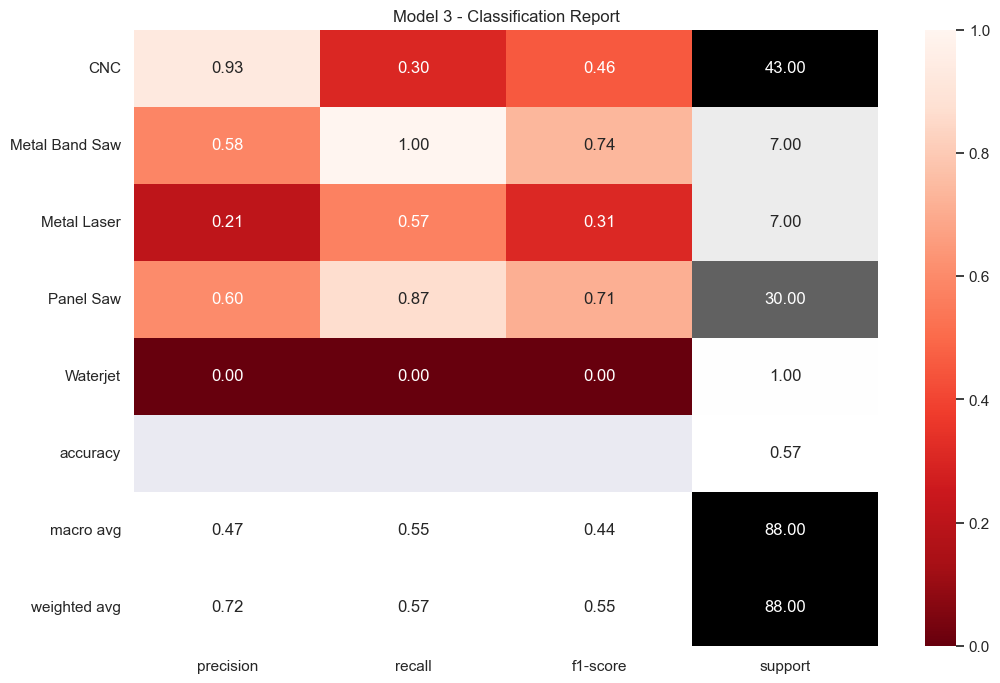

In [100]:
# create classification report and confuision matrix for first base model
show_classification_report_and_confusion_matrix(pointnet4, 
                                                all_preds4, 
                                                all_labels4, 
                                                classes,
                                                'Greens', 
                                                'Reds_r', 
                                                'Model 3 - Confusion Matrix', 
                                                'Model 3 - Classification Report',
                                                'Visualizations/3-Confusion_Matrix.png',
                                                'Visualizations/3-Classification_Report.png')

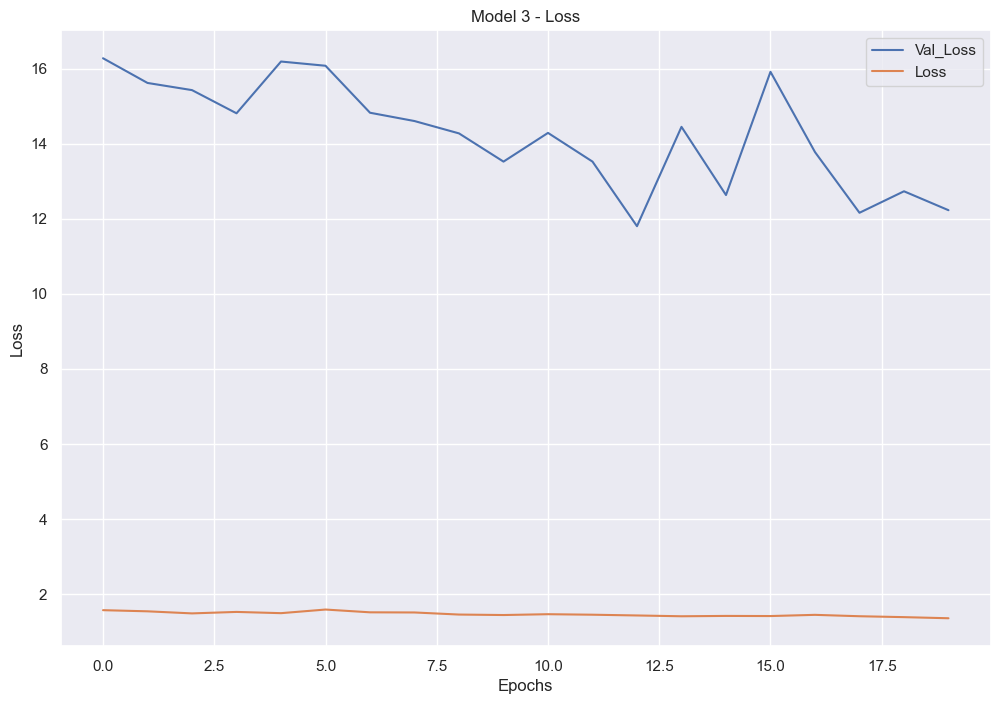

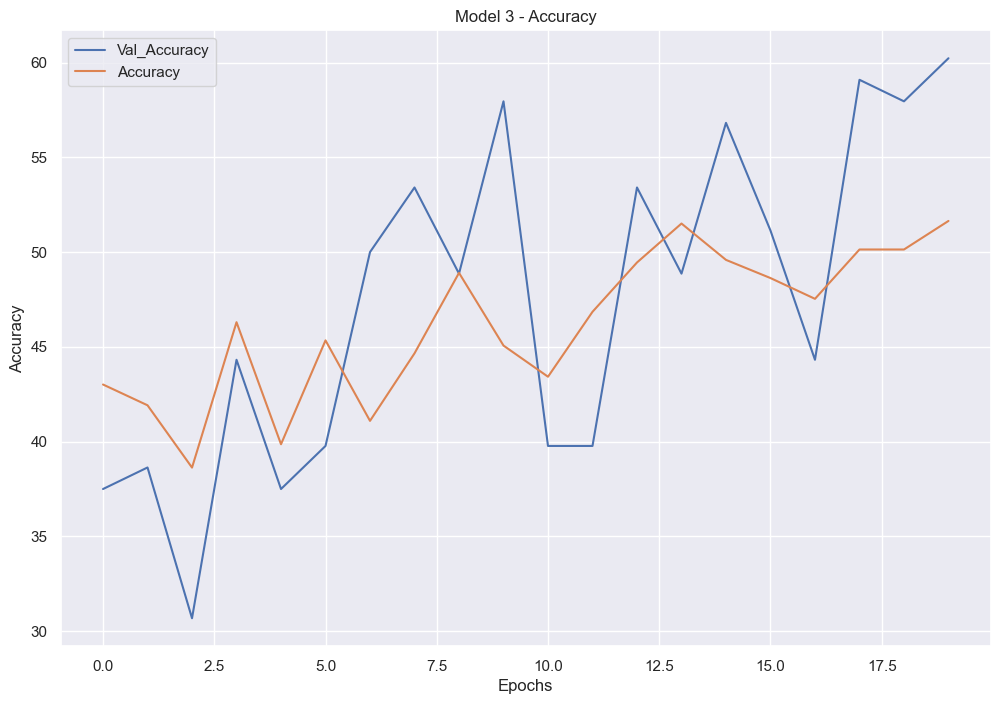

In [101]:
# visualize accuracy and loss
visualize_training_results(accuracy_loss_df4,
                          'Model 3 - Loss',
                          'Model 3 - Accuracy',
                          'Visualizations/3-Loss.png',
                          'Visualizations/3-Accuracy.png')

Model 3 clearly gave the worst results for CNC precision, F1-Score, and overall accuracy of the model, so we not be using this one.

## Model 4

Lets try a longer run of 40 epochs for model 3 and see what we end up with.

In [102]:
# Set epochs
epochs = 40

In [103]:
# set the device. If cuda is available, use cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pointnet5 = PointNet3()
pointnet5.to(device);

# Load a pre-trained model if it exists
# pointnet.load_state_dict(torch.load('../input/pointnet-for-3d-object-classification-pytorch/save.pth'))

# set optimizer to the adam optimizer
optimizer = torch.optim.AdamW(pointnet5.parameters(), lr=0.00025)

In [104]:
# Create train dataset
train_ds5 = MeshData(train_path, transform=Train_transforms(), num_samples=num_samples)
val_ds5 = MeshData(val_path, transform=Train_transforms(), num_samples=num_samples)

In [105]:
train_loader5 = DataLoader(dataset=train_ds4, batch_size=batch_size, shuffle=True)
val_loader5 = DataLoader(dataset=val_ds4, batch_size=batch_size, shuffle=True)

In [106]:
# run the training model
accuracy_loss5 = []
save_name5 = 'Pytorch_Model_Save/Model_4.pth'
train(pointnet5, train_loader5, val_loader5, epochs, accuracy_loss5, class_weight_tensor, save_name5)

[Epoch: 1, Batch:    5 /   92], loss: 0.792
[Epoch: 1, Batch:   10 /   92], loss: 0.887
[Epoch: 1, Batch:   15 /   92], loss: 0.745
[Epoch: 1, Batch:   20 /   92], loss: 0.919
[Epoch: 1, Batch:   25 /   92], loss: 0.869
[Epoch: 1, Batch:   30 /   92], loss: 0.833
[Epoch: 1, Batch:   35 /   92], loss: 0.802
[Epoch: 1, Batch:   40 /   92], loss: 0.810
[Epoch: 1, Batch:   45 /   92], loss: 0.764
[Epoch: 1, Batch:   50 /   92], loss: 0.747
[Epoch: 1, Batch:   55 /   92], loss: 0.818
[Epoch: 1, Batch:   60 /   92], loss: 0.764
[Epoch: 1, Batch:   65 /   92], loss: 0.831
[Epoch: 1, Batch:   70 /   92], loss: 0.767
[Epoch: 1, Batch:   75 /   92], loss: 0.805
[Epoch: 1, Batch:   80 /   92], loss: 0.727
[Epoch: 1, Batch:   85 /   92], loss: 0.861
[Epoch: 1, Batch:   90 /   92], loss: 0.756
Epoch time: 05m:44s - Valid Accuracy: 50 % - Accuracy: 34 % - Valid Loss: 17.505
[Epoch: 2, Batch:    5 /   92], loss: 0.778
[Epoch: 2, Batch:   10 /   92], loss: 0.820
[Epoch: 2, Batch:   15 /   92], loss: 0

In [107]:
# Set accuracy and loss dataframe
accuracy_loss_df5 = pd.DataFrame.from_records(accuracy_loss5)
accuracy_loss_df5 = accuracy_loss_df5.set_index('Epoch')

In [108]:
# load model and evaluate
current_model_dict = pointnet5.state_dict()
loaded_state_dict = torch.load(save_name5)
new_state_dict={k:v if v.size()==current_model_dict[k].size()  else  current_model_dict[k] for k,v in zip(current_model_dict.keys(), loaded_state_dict.values())}
pointnet5.load_state_dict(new_state_dict, strict=False)
pointnet5.eval();

In [109]:
# evaluate the model to get predictions and true labels
all_preds5 = []
all_labels5 = []
with torch.no_grad():
    for i, data in enumerate(val_loader5):
        print('Batch [%4d / %4d]' % (i+1, len(val_loader5)))
        
        inputs, labels = data['mesh'].float(), data['category']
        outputs, __, __ = pointnet5(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds5 += list(preds.numpy())
        all_labels5 += list(labels.numpy())

Batch [   1 /   11]
Batch [   2 /   11]
Batch [   3 /   11]
Batch [   4 /   11]
Batch [   5 /   11]
Batch [   6 /   11]
Batch [   7 /   11]
Batch [   8 /   11]
Batch [   9 /   11]
Batch [  10 /   11]
Batch [  11 /   11]


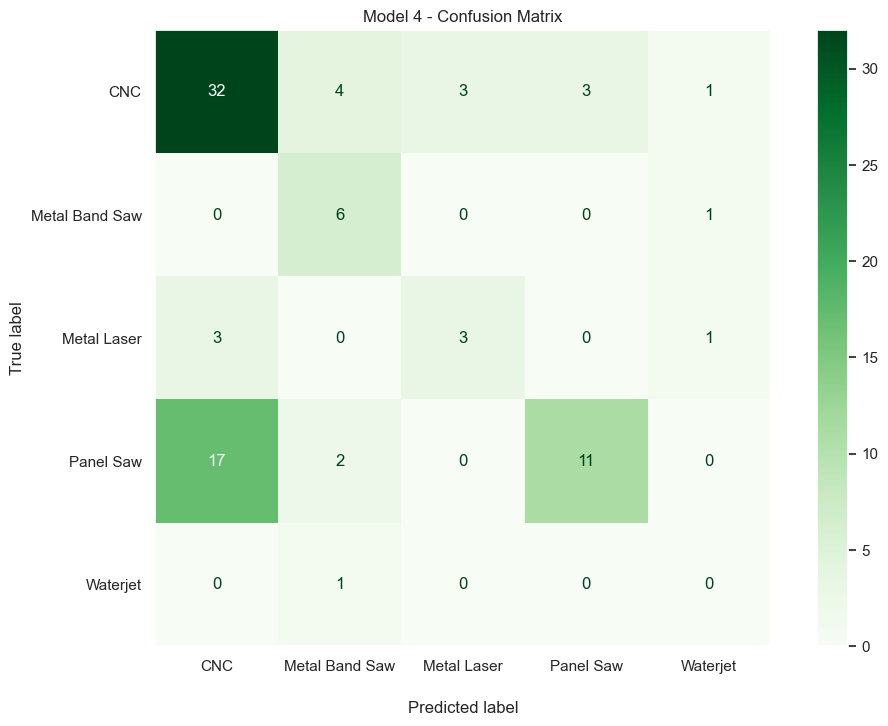

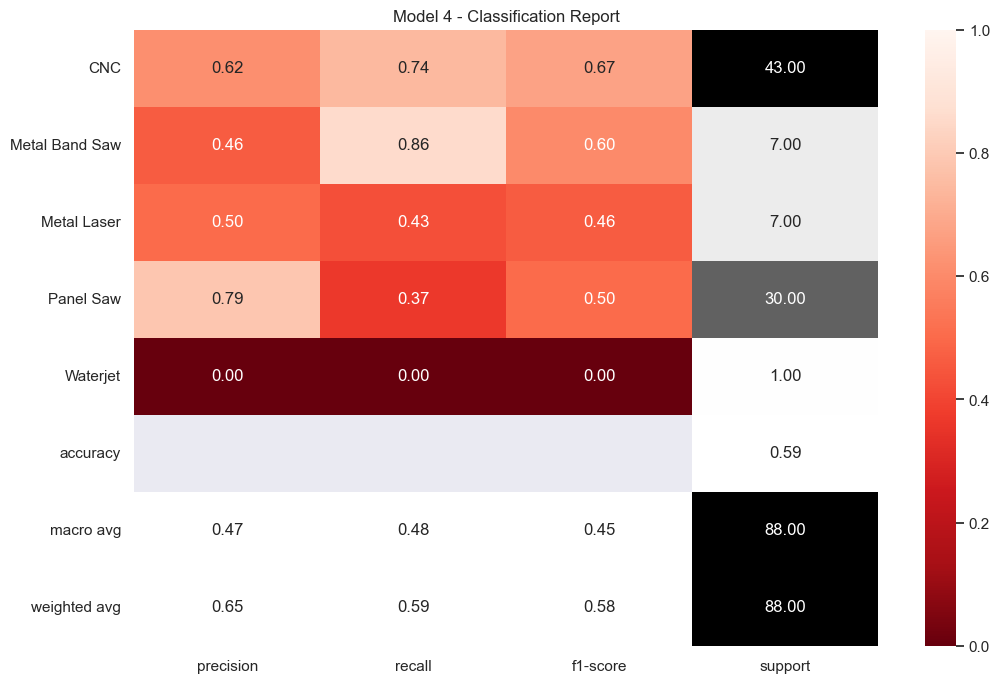

In [110]:
# create classification report and confuision matrix for first base model
show_classification_report_and_confusion_matrix(pointnet5, 
                                                all_preds5, 
                                                all_labels5, 
                                                classes,
                                                'Greens', 
                                                'Reds_r', 
                                                'Model 4 - Confusion Matrix', 
                                                'Model 4 - Classification Report',
                                                'Visualizations/4-Confusion_Matrix.png',
                                                'Visualizations/4-Classification_Report.png')

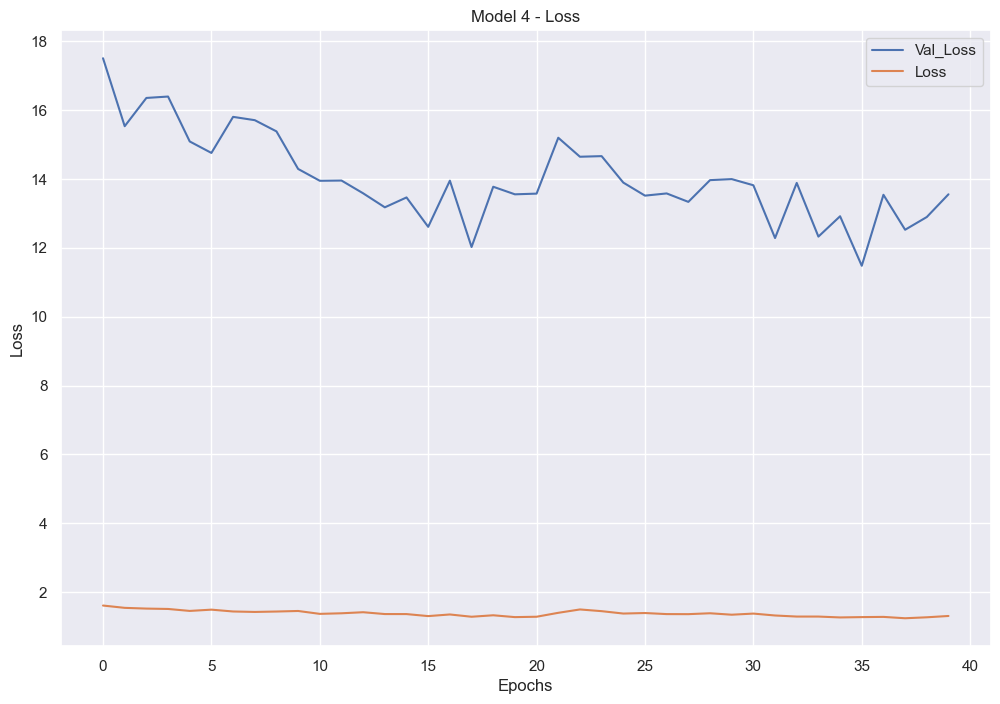

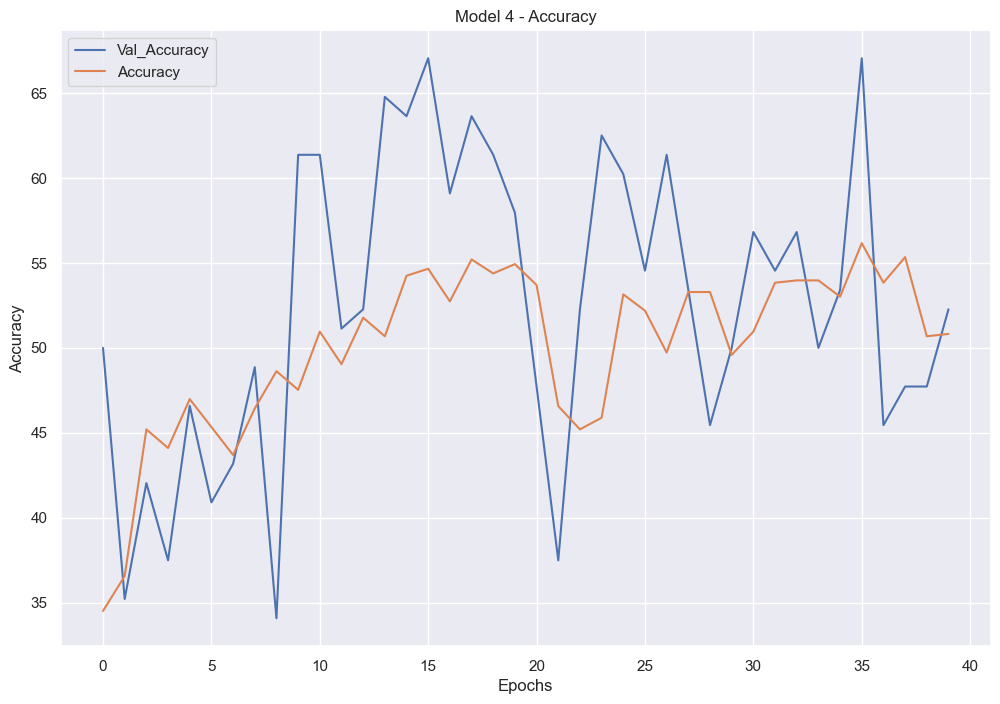

In [111]:
visualize_training_results(accuracy_loss_df5,
                          'Model 4 - Loss',
                          'Model 4 - Accuracy',
                          'Visualizations/4-Loss.png',
                          'Visualizations/4-Accuracy.png')

# Evaluation (Final Model Interpretation)

## Plot Correct and Incorrect Predictions

In [112]:
# setting final model 
model_fin = pointnet5
val_loader_fin = val_loader5
train_loader_fin = train_loader5
accuracy_loss_fin = accuracy_loss_df5
model_save = save_name5

In [113]:
# create lists of predictions and labels
all_preds_cor = []
all_labels_cor = []
class_pred_array = []
mesh_test_array = []

for i, data in enumerate(val_loader_fin, 0):
            inputs, labels = data['mesh'].to(device).float(), data['category']
            outputs, _, _ = model_fin(inputs.transpose(1,2))
            _, preds = torch.max(outputs.data, 1)
            all_preds_cor += list(preds.numpy())
            all_labels_cor += list(labels.numpy())
            class_pred_array.append(outputs)
            mesh_test_array.append(inputs)

In [114]:
# concatenate prediction array and test array
class_pred_array = torch.cat(class_pred_array)
mesh_test_array = torch.cat(mesh_test_array)

In [115]:
# Identify indexs of correct and incorrect identified meshes
correct = np.nonzero(np.asarray(all_labels_cor) == np.asarray(all_preds_cor))
incorrect = np.nonzero(np.asarray(all_labels_cor) != np.asarray(all_preds_cor))

C:\Users\Tim\AppData\Local\Temp\ipykernel_7420\3325721260.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3,3,i+1, projection='3d')


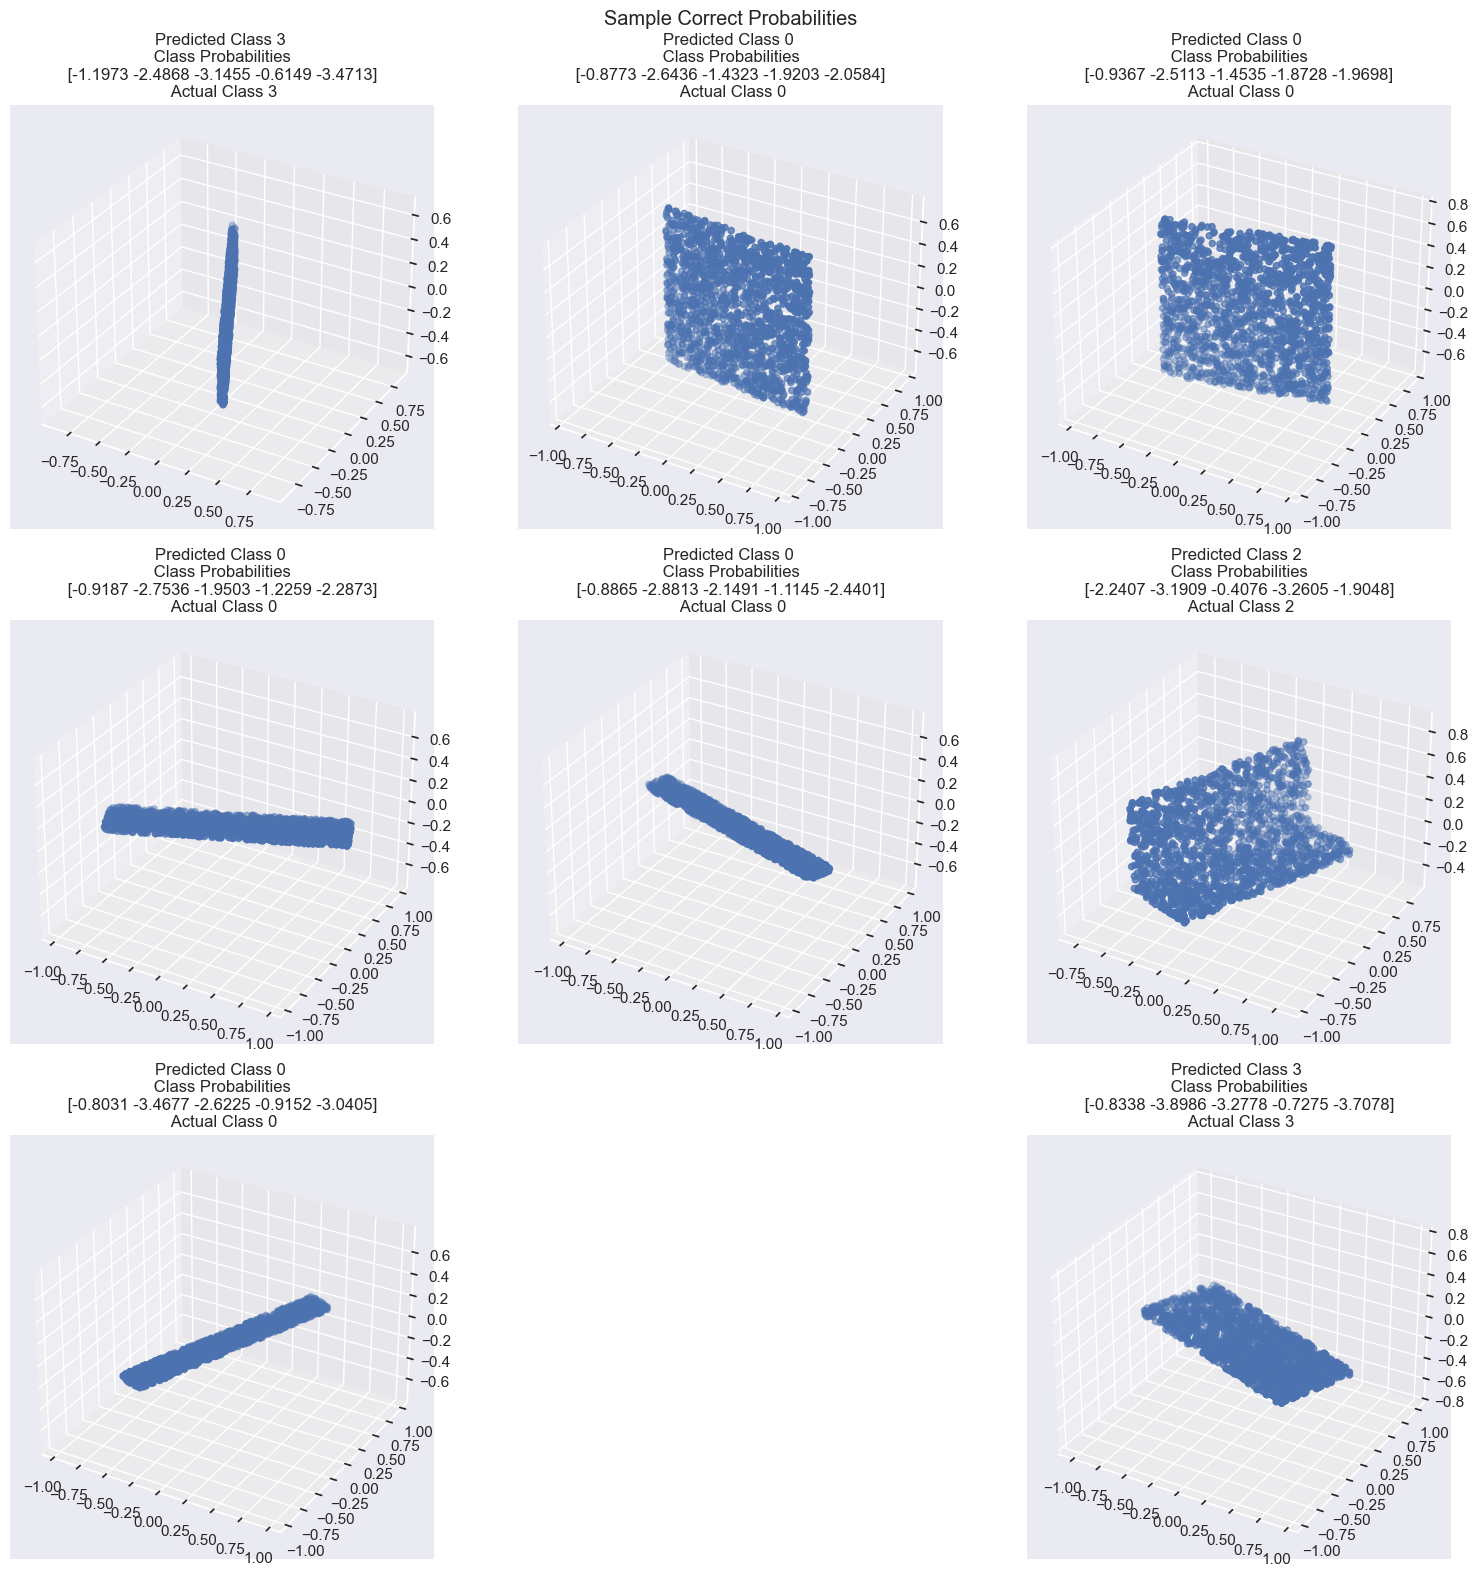

In [127]:
# Use a for loop to iterate through correct predictions,
# display the prediction values for each image and the actual class of the model
np.set_printoptions(precision=4)
correct_sample = np.random.choice(correct[0], size = 9)
i = 0
fig = plt.figure(figsize=(16,16))
fig.suptitle('Sample Correct Probabilities')
for c in correct_sample:
    ax = plt.subplot(3,3,i+1, projection='3d')
    mesh = mesh_test_array[c]
    ax.scatter(mesh[:,0], mesh[:,1], mesh[:,2])
    plt.title(
        'Predicted Class {} \n Class Probabilities \n {} \n Actual Class {}'.format(
            all_preds_cor[c], 
            class_pred_array[c].detach().numpy(), 
            all_labels_cor[c]))
    plt.axis('equal')
    plt.tight_layout()
    i += 1

plt.savefig('Visualizations/Correct-Meshes.png', bbox_inches='tight')
plt.show();

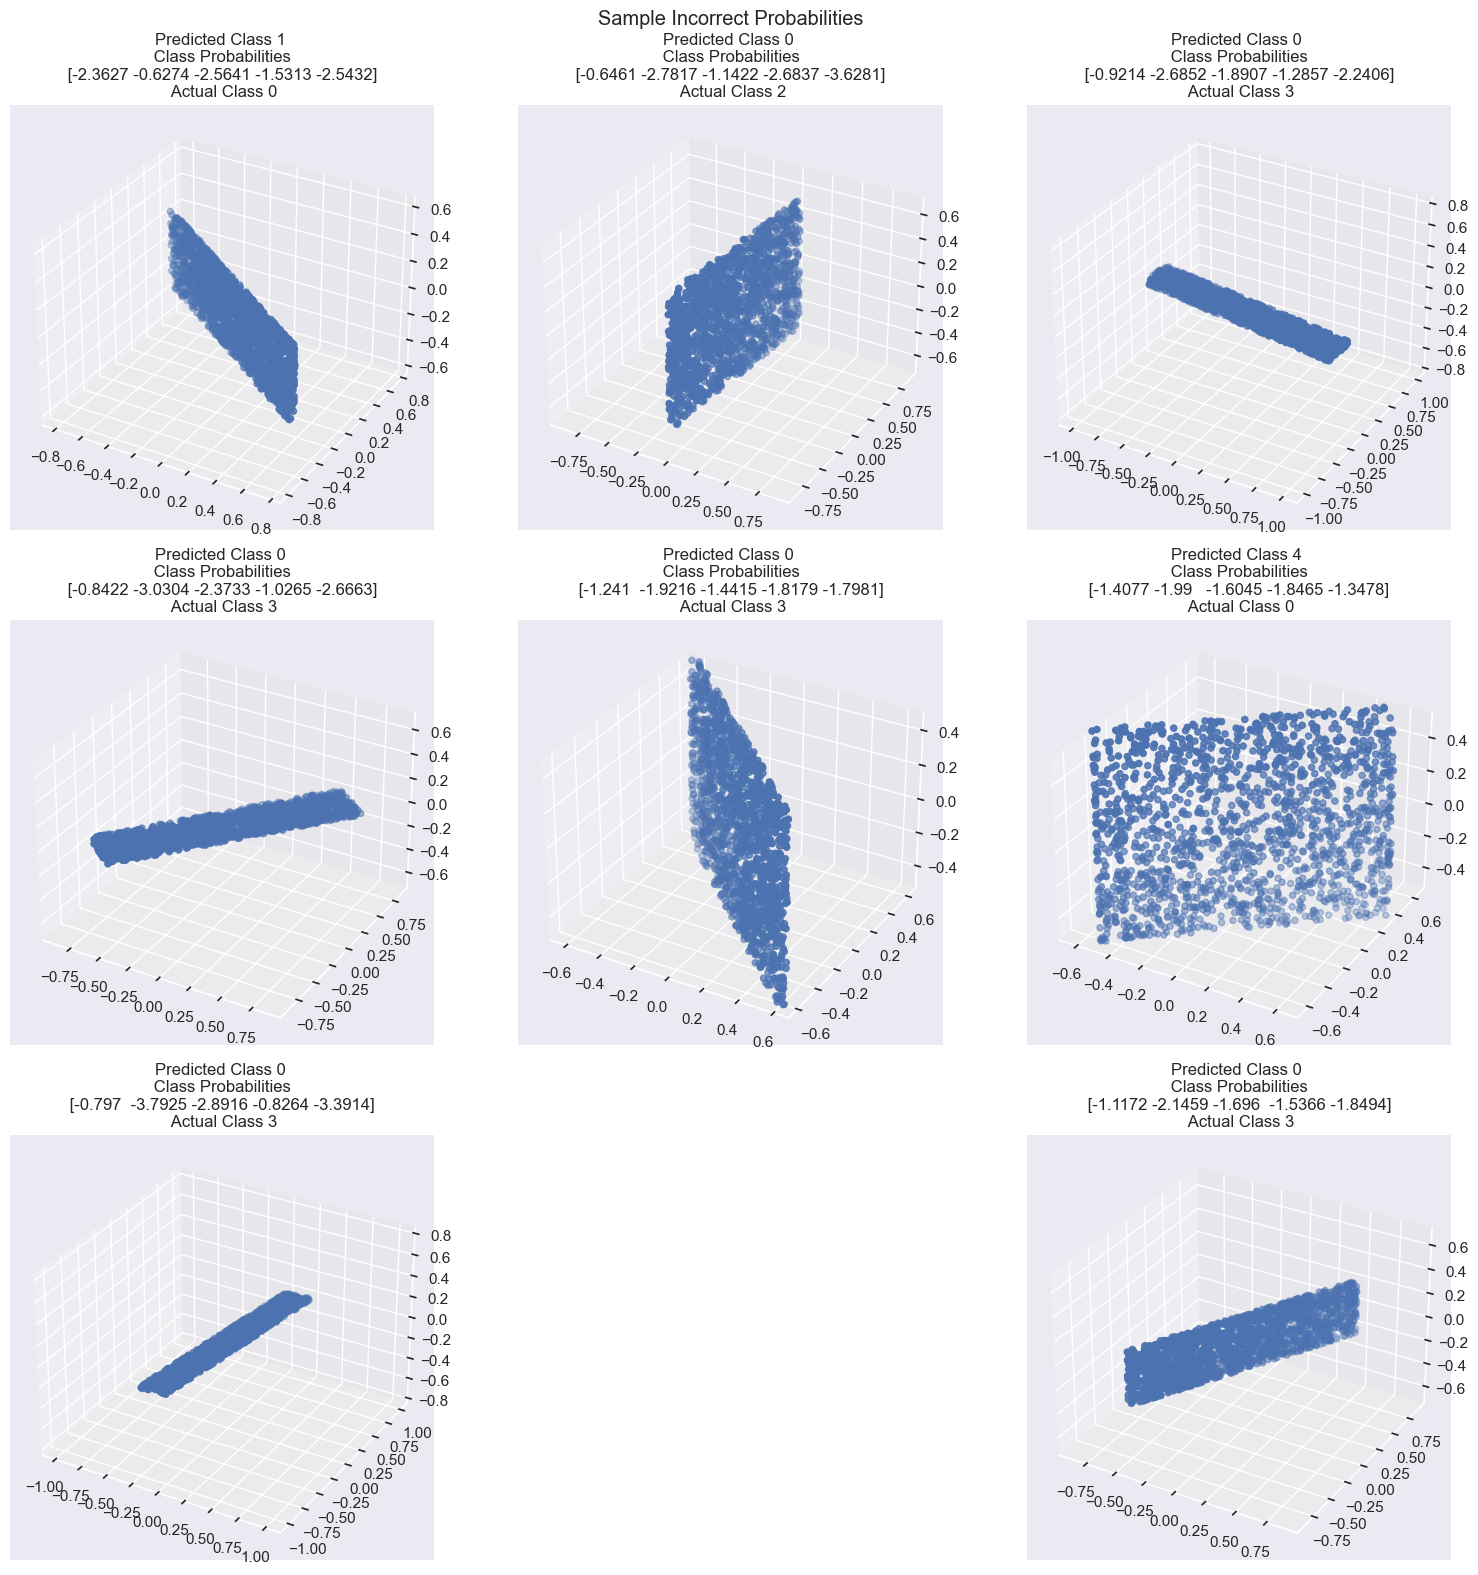

In [134]:
# Use a for loop to iterate through incorrect predictions,
# display the prediction values for each image and the actual class of the model
np.set_printoptions(precision=4)
incorrect_sample = np.random.choice(incorrect[0], size = 9)
i = 0
fig = plt.figure(figsize=(16,16))
fig.suptitle('Sample Incorrect Probabilities')
for c in incorrect_sample:
    ax = plt.subplot(3,3,i+1, projection='3d')
    mesh = mesh_test_array[c]
    ax.scatter(mesh[:,0], mesh[:,1], mesh[:,2])
    # ax.set_xlim3d(0, 60)
    # ax.set_ylim3d(0, 60)
    # ax.set_zlim3d(0, 60)
    plt.title(
        'Predicted Class {} \n Class Probabilities \n {} \n Actual Class {}'.format(
            all_preds_cor[c], 
            class_pred_array[c].detach().numpy(), 
            all_labels_cor[c]))
    plt.axis('equal')
    plt.tight_layout()
    i += 1

plt.savefig('Visualizations/Incorrect-Meshes.png', bbox_inches='tight')
plt.show();

## Final Model Evaluation

In [118]:
# Assign train path and validation path
test_path = 'Meshes/1B_FabInc/test'

# Create train and validation datasets
test_ds = MeshData(test_path, num_samples=num_samples)

In [119]:
# Create train and validation dataloader
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)


In [120]:
# load model and evaluate
current_model_dict = model_fin.state_dict()
loaded_state_dict = torch.load(model_save)
new_state_dict={k:v if v.size()==current_model_dict[k].size()  else  current_model_dict[k] for k,v in zip(current_model_dict.keys(), loaded_state_dict.values())}
model_fin.load_state_dict(new_state_dict, strict=False)
model_fin.eval();

In [121]:
# evaluate the model to get predictions and true labels
all_preds_fin = []
all_labels_fin = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        print('Batch [%4d / %4d]' % (i+1, len(test_loader)))
        
        inputs, labels = data['mesh'].float(), data['category']
        outputs, __, __ = model_fin(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds_fin += list(preds.numpy())
        all_labels_fin += list(labels.numpy())

Batch [   1 /   12]
Batch [   2 /   12]
Batch [   3 /   12]
Batch [   4 /   12]
Batch [   5 /   12]
Batch [   6 /   12]
Batch [   7 /   12]
Batch [   8 /   12]
Batch [   9 /   12]
Batch [  10 /   12]
Batch [  11 /   12]
Batch [  12 /   12]


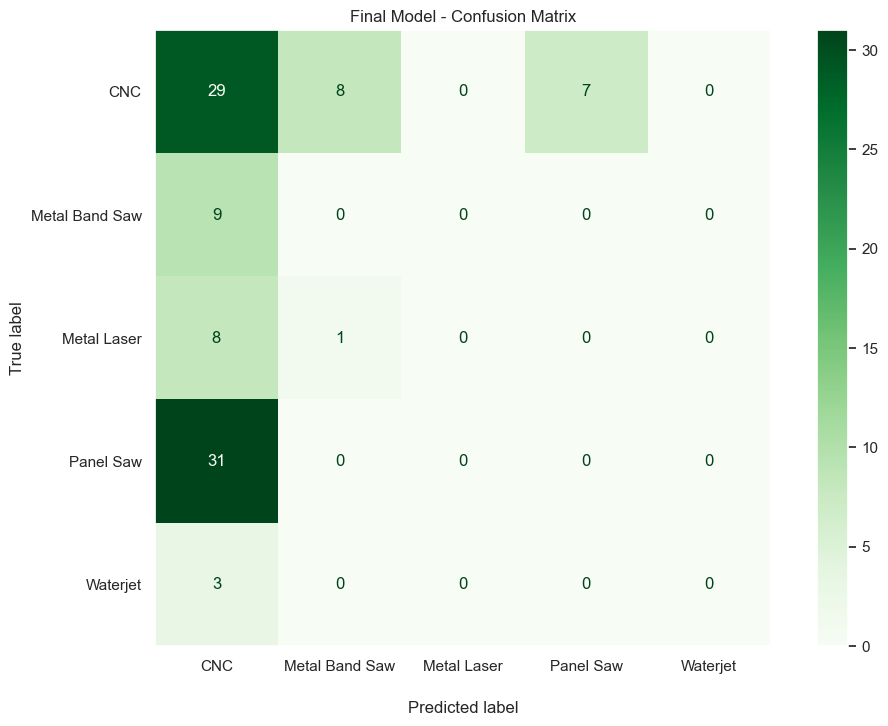

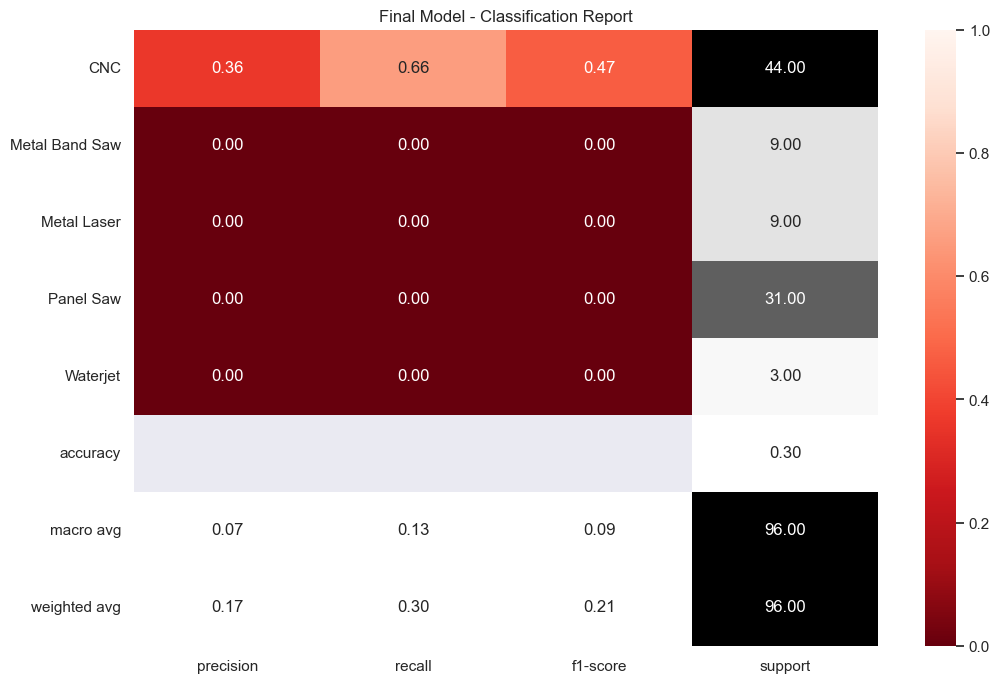

In [122]:
# create classification report and confuision matrix for first base model
show_classification_report_and_confusion_matrix(model_fin, 
                                                all_preds_fin, 
                                                all_labels_fin, 
                                                classes,
                                                'Greens', 
                                                'Reds_r', 
                                                'Final Model - Confusion Matrix', 
                                                'Final Model - Classification Report',
                                                'Visualizations/Final-Confusion_Matrix.png',
                                                'Visualizations/Final-Classification_Report.png')

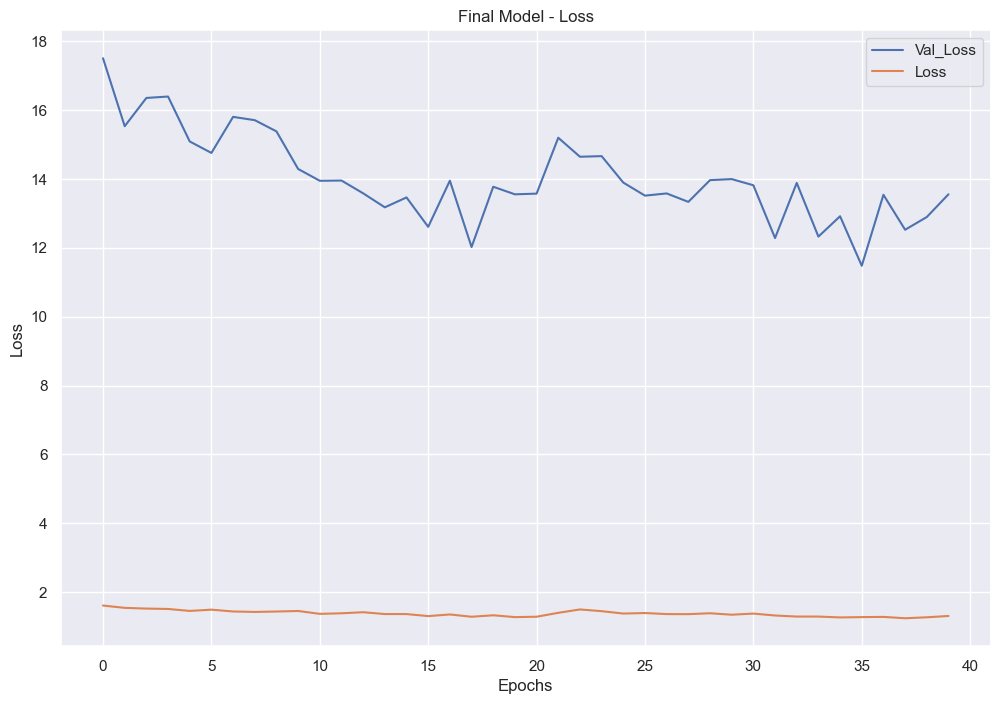

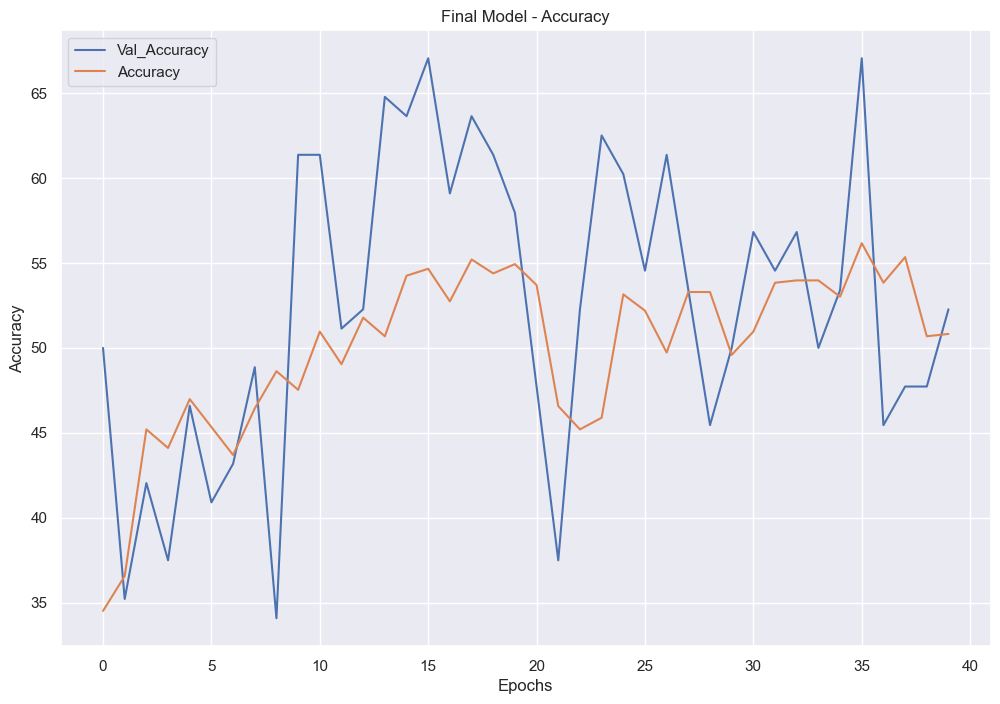

In [123]:
# visualize accuracy and loss
visualize_training_results(accuracy_loss_fin,
                          'Final Model - Loss',
                          'Final Model - Accuracy',
                          'Visualizations/Final-Loss.png',
                          'Visualizations/Final-Accuracy.png')

# Recommendations

The client is looking for an algorithm that can automatically assign parts to different cutting machine processes. While our model does not have the accuracy we would want across all classes, it does get the closest to the precision we are looking for in the most expensive (CNC) class. The ultimate goal of this project is to implement this machine learning algorithm for use in the engineering department. While the algorithm is not ready to be fully implemented, there are some actionable recommendations that the company can take right now:

- Engineers should be required to triple check assigning parts to the CNC class, as this class costs 71% of the total cost for the company.

- The CNC class has the highest time investment of any other class. Given the amount of time incurred on each machine currently (30 minutes cycle time), it would be beneficial to complete a return on investment analysis of tools and methods that could decrease this time. We are not sure of the tools and methods currently in use, but automatic feed conveyors and material handling systems are just some tools to decrease the cycle time on these machines.

- That are specific features of a part that will dictate what manufacturing process the part might undergo. There seems to be a consistent formula that is followed, so in order to reduce engineering time this formula can be written in a flow diagram which can be used by an administrative member of team who would assign manufacturing processes instead.

## Model Implementation

- The algorithm can be used for a probationary 90 day peiod to automatically assign the CNC designation to parts. It will not be used for any other class or parts during this time. During this time, the model will also be improved by integrating the next steps detailed below. 

- All items designated not CNC will be checked by the engineering team to assign them to the correct processes.

- This model should be improved during the 90 day probationary period, and reevaluated at that time for the precision and F1-score of the model. If the model passes a 99% for the metrics, then the model can be put into full deployment by being applied to classify manufacturing processes for the department.

# Next Steps

Further analysis could yield additional insights such as:

- In the cost material analysis, we would want to calculate the square footage of each individual part and then use that as a basis to determine more accurate costs for each part based on the current dataset

- In the time cost analysis, we would want to implement an analysis program to each machine that would store the part's program and run time for each part's program (depending on the machine, this can include load, unload and machine time), in order to have a more accurate average of time estimates per machine. Those time estimates would then be fed into a program which could estimate program run times for the part models that we have in the dataset.

- Increasing the amount of data that the algorithm trains on would give a larger variety of parts to pull from. While 1,000 3D models is a good start, 10,000 or 20, 000 would be even better for improving the performance of the model.

- Integrating the materials into the modeling would definitely improve the model performance simply because the machines can only cut certain materials.

- The nueral network modeling was accomplished by using the PointNet nueral network architecture. The data would benefit from having another model or two that had a different architecture, just to be able to compare the differences between them. For example, integrating the face normals of the meshes would contribute to improving performance for the model as it would be able to analyze the mesh face information along with the mesh vertex information.

- If possible, since that data is coming from 3d models and not the real world, it would be ideal to have the data in a format that is cleaner if possible such as a step file or other nurbs file. Currently the data science industry does not have a methodology for processing this data due to it being "unstructured".

- After the model has reached a point where full deployment is possible, the next project to undertake would be to handle the sequencing of the assembly of these cut components to start to work on reducing assembly time on the floor.

# Conclusion

In conclusion, we were not close to the required results the company originally asked for. But this does show what the lack of information and time will result in for a project. If the company had supplied additional 3d models, 